In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : True,
    'balance_bins'  : 1000,
    'balance_ratio' : 0.5,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1000_1_05_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1471814, 828)
(1471814, 1)
validation
(173867, 828)
(173867, 1)
test
(208487, 828)
(208487, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/148 [..............................] - ETA: 4:04 - loss: 0.0482 - STD: 1.1880e-04 - MAE: 0.1855

  3/148 [..............................] - ETA: 3s - loss: 0.0396 - STD: 3.1790e-04 - MAE: 0.1613  

  5/148 [>.............................] - ETA: 3s - loss: 0.0391 - STD: 3.9173e-04 - MAE: 0.1578

  8/148 [>.............................] - ETA: 3s - loss: 0.0349 - STD: 5.7848e-04 - MAE: 0.1510

 10/148 [=>............................] - ETA: 3s - loss: 0.0341 - STD: 7.2241e-04 - MAE: 0.1510

 12/148 [=>............................] - ETA: 3s - loss: 0.0332 - STD: 8.5441e-04 - MAE: 0.1500

 15/148 [==>...........................] - ETA: 3s - loss: 0.0319 - STD: 0.0010 - MAE: 0.1475    

 17/148 [==>...........................] - ETA: 3s - loss: 0.0315 - STD: 0.0011 - MAE: 0.1463

 19/148 [==>...........................] - ETA: 3s - loss: 0.0310 - STD: 0.0012 - MAE: 0.1453

 21/148 [===>..........................] - ETA: 3s - loss: 0.0306 - STD: 0.0013 - MAE: 0.1445

 23/148 [===>..........................] - ETA: 3s - loss: 0.0302 - STD: 0.0015 - MAE: 0.1440

 25/148 [====>.........................] - ETA: 3s - loss: 0.0299 - STD: 0.0016 - MAE: 0.1436

 27/148 [====>.........................] - ETA: 3s - loss: 0.0296 - STD: 0.0018 - MAE: 0.1432

 29/148 [====>.........................] - ETA: 3s - loss: 0.0293 - STD: 0.0020 - MAE: 0.1427

 31/148 [=====>........................] - ETA: 2s - loss: 0.0291 - STD: 0.0022 - MAE: 0.1422

 33/148 [=====>........................] - ETA: 2s - loss: 0.0289 - STD: 0.0024 - MAE: 0.1418

 36/148 [======>.......................] - ETA: 2s - loss: 0.0286 - STD: 0.0029 - MAE: 0.1412

 39/148 [======>.......................] - ETA: 2s - loss: 0.0283 - STD: 0.0035 - MAE: 0.1408

 42/148 [=======>......................] - ETA: 2s - loss: 0.0280 - STD: 0.0043 - MAE: 0.1402

 44/148 [=======>......................] - ETA: 2s - loss: 0.0278 - STD: 0.0050 - MAE: 0.1398

 47/148 [========>.....................] - ETA: 2s - loss: 0.0274 - STD: 0.0063 - MAE: 0.1390

 50/148 [=========>....................] - ETA: 2s - loss: 0.0271 - STD: 0.0081 - MAE: 0.1382

 52/148 [=========>....................] - ETA: 2s - loss: 0.0268 - STD: 0.0096 - MAE: 0.1376

 54/148 [=========>....................] - ETA: 2s - loss: 0.0266 - STD: 0.0112 - MAE: 0.1370

 56/148 [==========>...................] - ETA: 2s - loss: 0.0264 - STD: 0.0131 - MAE: 0.1363

 59/148 [==========>...................] - ETA: 2s - loss: 0.0260 - STD: 0.0162 - MAE: 0.1352

 62/148 [===========>..................] - ETA: 2s - loss: 0.0257 - STD: 0.0193 - MAE: 0.1341

 64/148 [===========>..................] - ETA: 2s - loss: 0.0255 - STD: 0.0213 - MAE: 0.1334

 66/148 [============>.................] - ETA: 2s - loss: 0.0252 - STD: 0.0232 - MAE: 0.1327

 69/148 [============>.................] - ETA: 1s - loss: 0.0249 - STD: 0.0257 - MAE: 0.1317

 71/148 [=============>................] - ETA: 1s - loss: 0.0248 - STD: 0.0271 - MAE: 0.1311

 73/148 [=============>................] - ETA: 1s - loss: 0.0246 - STD: 0.0285 - MAE: 0.1305

 75/148 [==============>...............] - ETA: 1s - loss: 0.0244 - STD: 0.0298 - MAE: 0.1299

 77/148 [==============>...............] - ETA: 1s - loss: 0.0242 - STD: 0.0311 - MAE: 0.1294

 79/148 [===============>..............] - ETA: 1s - loss: 0.0241 - STD: 0.0324 - MAE: 0.1288

 82/148 [===============>..............] - ETA: 1s - loss: 0.0238 - STD: 0.0343 - MAE: 0.1280

 84/148 [================>.............] - ETA: 1s - loss: 0.0237 - STD: 0.0356 - MAE: 0.1274

 86/148 [================>.............] - ETA: 1s - loss: 0.0235 - STD: 0.0369 - MAE: 0.1269

 88/148 [================>.............] - ETA: 1s - loss: 0.0234 - STD: 0.0381 - MAE: 0.1263

 90/148 [=================>............] - ETA: 1s - loss: 0.0232 - STD: 0.0393 - MAE: 0.1258

 93/148 [=================>............] - ETA: 1s - loss: 0.0230 - STD: 0.0409 - MAE: 0.1249

 95/148 [==================>...........] - ETA: 1s - loss: 0.0228 - STD: 0.0419 - MAE: 0.1244

 97/148 [==================>...........] - ETA: 1s - loss: 0.0227 - STD: 0.0430 - MAE: 0.1238

 99/148 [===================>..........] - ETA: 1s - loss: 0.0225 - STD: 0.0440 - MAE: 0.1233

101/148 [===================>..........] - ETA: 1s - loss: 0.0224 - STD: 0.0450 - MAE: 0.1228

103/148 [===================>..........] - ETA: 1s - loss: 0.0222 - STD: 0.0461 - MAE: 0.1222

105/148 [====================>.........] - ETA: 1s - loss: 0.0221 - STD: 0.0472 - MAE: 0.1217

107/148 [====================>.........] - ETA: 1s - loss: 0.0220 - STD: 0.0482 - MAE: 0.1212

110/148 [=====================>........] - ETA: 0s - loss: 0.0218 - STD: 0.0497 - MAE: 0.1204

112/148 [=====================>........] - ETA: 0s - loss: 0.0217 - STD: 0.0507 - MAE: 0.1200

114/148 [======================>.......] - ETA: 0s - loss: 0.0215 - STD: 0.0516 - MAE: 0.1195

117/148 [======================>.......] - ETA: 0s - loss: 0.0214 - STD: 0.0529 - MAE: 0.1188

120/148 [=======================>......] - ETA: 0s - loss: 0.0212 - STD: 0.0542 - MAE: 0.1181

123/148 [=======================>......] - ETA: 0s - loss: 0.0210 - STD: 0.0555 - MAE: 0.1175

125/148 [========================>.....] - ETA: 0s - loss: 0.0209 - STD: 0.0562 - MAE: 0.1170

128/148 [========================>.....] - ETA: 0s - loss: 0.0207 - STD: 0.0574 - MAE: 0.1164

131/148 [=========================>....] - ETA: 0s - loss: 0.0206 - STD: 0.0585 - MAE: 0.1158

133/148 [=========================>....] - ETA: 0s - loss: 0.0205 - STD: 0.0592 - MAE: 0.1154

134/148 [==========================>...] - ETA: 0s - loss: 0.0205 - STD: 0.0596 - MAE: 0.1152

137/148 [==========================>...] - ETA: 0s - loss: 0.0203 - STD: 0.0606 - MAE: 0.1146

139/148 [===========================>..] - ETA: 0s - loss: 0.0202 - STD: 0.0613 - MAE: 0.1142

142/148 [===========================>..] - ETA: 0s - loss: 0.0200 - STD: 0.0623 - MAE: 0.1136

144/148 [============================>.] - ETA: 0s - loss: 0.0199 - STD: 0.0629 - MAE: 0.1132

147/148 [============================>.] - ETA: 0s - loss: 0.0198 - STD: 0.0639 - MAE: 0.1127

148/148 [==============================] - 7s 36ms/step - loss: 0.0198 - STD: 0.0642 - MAE: 0.1125 - val_loss: 0.0106 - val_STD: 0.0850 - val_MAE: 0.0810


Epoch 2/10000


  1/148 [..............................] - ETA: 8s - loss: 0.0131 - STD: 0.1098 - MAE: 0.0867

  3/148 [..............................] - ETA: 3s - loss: 0.0129 - STD: 0.1105 - MAE: 0.0859

  5/148 [>.............................] - ETA: 3s - loss: 0.0130 - STD: 0.1108 - MAE: 0.0858

  7/148 [>.............................] - ETA: 3s - loss: 0.0130 - STD: 0.1108 - MAE: 0.0859

  9/148 [>.............................] - ETA: 3s - loss: 0.0130 - STD: 0.1113 - MAE: 0.0860

 11/148 [=>............................] - ETA: 3s - loss: 0.0129 - STD: 0.1118 - MAE: 0.0857

 14/148 [=>............................] - ETA: 3s - loss: 0.0128 - STD: 0.1118 - MAE: 0.0853

 16/148 [==>...........................] - ETA: 3s - loss: 0.0127 - STD: 0.1120 - MAE: 0.0851

 18/148 [==>...........................] - ETA: 3s - loss: 0.0127 - STD: 0.1122 - MAE: 0.0850

 20/148 [===>..........................] - ETA: 3s - loss: 0.0126 - STD: 0.1122 - MAE: 0.0847

 22/148 [===>..........................] - ETA: 3s - loss: 0.0126 - STD: 0.1124 - MAE: 0.0844

 24/148 [===>..........................] - ETA: 3s - loss: 0.0125 - STD: 0.1125 - MAE: 0.0842

 26/148 [====>.........................] - ETA: 3s - loss: 0.0126 - STD: 0.1124 - MAE: 0.0842

 28/148 [====>.........................] - ETA: 3s - loss: 0.0126 - STD: 0.1125 - MAE: 0.0845

 30/148 [=====>........................] - ETA: 3s - loss: 0.0126 - STD: 0.1130 - MAE: 0.0844

 32/148 [=====>........................] - ETA: 2s - loss: 0.0126 - STD: 0.1131 - MAE: 0.0845

 34/148 [=====>........................] - ETA: 2s - loss: 0.0126 - STD: 0.1130 - MAE: 0.0843

 37/148 [======>.......................] - ETA: 2s - loss: 0.0125 - STD: 0.1132 - MAE: 0.0842

 39/148 [======>.......................] - ETA: 2s - loss: 0.0125 - STD: 0.1131 - MAE: 0.0841

 41/148 [=======>......................] - ETA: 2s - loss: 0.0125 - STD: 0.1133 - MAE: 0.0839

 43/148 [=======>......................] - ETA: 2s - loss: 0.0124 - STD: 0.1134 - MAE: 0.0838

 45/148 [========>.....................] - ETA: 2s - loss: 0.0124 - STD: 0.1134 - MAE: 0.0836

 48/148 [========>.....................] - ETA: 2s - loss: 0.0124 - STD: 0.1136 - MAE: 0.0835

 50/148 [=========>....................] - ETA: 2s - loss: 0.0123 - STD: 0.1137 - MAE: 0.0834

 52/148 [=========>....................] - ETA: 2s - loss: 0.0123 - STD: 0.1140 - MAE: 0.0833

 55/148 [==========>...................] - ETA: 2s - loss: 0.0123 - STD: 0.1143 - MAE: 0.0831

 58/148 [==========>...................] - ETA: 2s - loss: 0.0122 - STD: 0.1145 - MAE: 0.0828

 60/148 [===========>..................] - ETA: 2s - loss: 0.0122 - STD: 0.1147 - MAE: 0.0827

 62/148 [===========>..................] - ETA: 2s - loss: 0.0121 - STD: 0.1149 - MAE: 0.0825

 65/148 [============>.................] - ETA: 2s - loss: 0.0121 - STD: 0.1152 - MAE: 0.0823

 67/148 [============>.................] - ETA: 2s - loss: 0.0120 - STD: 0.1155 - MAE: 0.0822

 69/148 [============>.................] - ETA: 2s - loss: 0.0121 - STD: 0.1156 - MAE: 0.0822

 71/148 [=============>................] - ETA: 1s - loss: 0.0121 - STD: 0.1156 - MAE: 0.0825

 73/148 [=============>................] - ETA: 1s - loss: 0.0121 - STD: 0.1156 - MAE: 0.0823

 75/148 [==============>...............] - ETA: 1s - loss: 0.0121 - STD: 0.1157 - MAE: 0.0824

 77/148 [==============>...............] - ETA: 1s - loss: 0.0121 - STD: 0.1159 - MAE: 0.0824

 79/148 [===============>..............] - ETA: 1s - loss: 0.0121 - STD: 0.1158 - MAE: 0.0824

 82/148 [===============>..............] - ETA: 1s - loss: 0.0121 - STD: 0.1157 - MAE: 0.0824

 84/148 [================>.............] - ETA: 1s - loss: 0.0121 - STD: 0.1158 - MAE: 0.0824

 86/148 [================>.............] - ETA: 1s - loss: 0.0121 - STD: 0.1158 - MAE: 0.0824

 88/148 [================>.............] - ETA: 1s - loss: 0.0121 - STD: 0.1157 - MAE: 0.0823

 90/148 [=================>............] - ETA: 1s - loss: 0.0121 - STD: 0.1158 - MAE: 0.0823

 92/148 [=================>............] - ETA: 1s - loss: 0.0120 - STD: 0.1157 - MAE: 0.0822

 94/148 [==================>...........] - ETA: 1s - loss: 0.0120 - STD: 0.1158 - MAE: 0.0821

 96/148 [==================>...........] - ETA: 1s - loss: 0.0120 - STD: 0.1158 - MAE: 0.0820

 99/148 [===================>..........] - ETA: 1s - loss: 0.0119 - STD: 0.1159 - MAE: 0.0819

101/148 [===================>..........] - ETA: 1s - loss: 0.0119 - STD: 0.1160 - MAE: 0.0818

103/148 [===================>..........] - ETA: 1s - loss: 0.0119 - STD: 0.1161 - MAE: 0.0817

105/148 [====================>.........] - ETA: 1s - loss: 0.0119 - STD: 0.1162 - MAE: 0.0816

107/148 [====================>.........] - ETA: 1s - loss: 0.0119 - STD: 0.1163 - MAE: 0.0815

109/148 [=====================>........] - ETA: 0s - loss: 0.0118 - STD: 0.1164 - MAE: 0.0814

111/148 [=====================>........] - ETA: 0s - loss: 0.0118 - STD: 0.1165 - MAE: 0.0813

114/148 [======================>.......] - ETA: 0s - loss: 0.0118 - STD: 0.1167 - MAE: 0.0812

117/148 [======================>.......] - ETA: 0s - loss: 0.0117 - STD: 0.1169 - MAE: 0.0810

120/148 [=======================>......] - ETA: 0s - loss: 0.0117 - STD: 0.1171 - MAE: 0.0809

122/148 [=======================>......] - ETA: 0s - loss: 0.0117 - STD: 0.1173 - MAE: 0.0808

124/148 [========================>.....] - ETA: 0s - loss: 0.0117 - STD: 0.1174 - MAE: 0.0807

127/148 [========================>.....] - ETA: 0s - loss: 0.0116 - STD: 0.1176 - MAE: 0.0806

130/148 [=========================>....] - ETA: 0s - loss: 0.0116 - STD: 0.1178 - MAE: 0.0804

132/148 [=========================>....] - ETA: 0s - loss: 0.0116 - STD: 0.1178 - MAE: 0.0804

135/148 [==========================>...] - ETA: 0s - loss: 0.0115 - STD: 0.1181 - MAE: 0.0803

138/148 [==========================>...] - ETA: 0s - loss: 0.0115 - STD: 0.1182 - MAE: 0.0802

141/148 [===========================>..] - ETA: 0s - loss: 0.0115 - STD: 0.1184 - MAE: 0.0801

143/148 [===========================>..] - ETA: 0s - loss: 0.0115 - STD: 0.1184 - MAE: 0.0800

146/148 [============================>.] - ETA: 0s - loss: 0.0115 - STD: 0.1186 - MAE: 0.0799

148/148 [==============================] - 4s 28ms/step - loss: 0.0114 - STD: 0.1187 - MAE: 0.0798 - val_loss: 0.0087 - val_STD: 0.0884 - val_MAE: 0.0727


Epoch 3/10000


  1/148 [..............................] - ETA: 9s - loss: 0.0098 - STD: 0.1243 - MAE: 0.0729

  3/148 [..............................] - ETA: 3s - loss: 0.0103 - STD: 0.1239 - MAE: 0.0744

  6/148 [>.............................] - ETA: 3s - loss: 0.0116 - STD: 0.1256 - MAE: 0.0801

  9/148 [>.............................] - ETA: 3s - loss: 0.0114 - STD: 0.1250 - MAE: 0.0795

 11/148 [=>............................] - ETA: 3s - loss: 0.0114 - STD: 0.1247 - MAE: 0.0793

 13/148 [=>............................] - ETA: 3s - loss: 0.0112 - STD: 0.1240 - MAE: 0.0785

 15/148 [==>...........................] - ETA: 3s - loss: 0.0111 - STD: 0.1239 - MAE: 0.0784

 17/148 [==>...........................] - ETA: 3s - loss: 0.0111 - STD: 0.1239 - MAE: 0.0782

 19/148 [==>...........................] - ETA: 3s - loss: 0.0110 - STD: 0.1233 - MAE: 0.0779

 21/148 [===>..........................] - ETA: 3s - loss: 0.0110 - STD: 0.1230 - MAE: 0.0781

 23/148 [===>..........................] - ETA: 3s - loss: 0.0110 - STD: 0.1233 - MAE: 0.0780

 25/148 [====>.........................] - ETA: 3s - loss: 0.0110 - STD: 0.1229 - MAE: 0.0779

 27/148 [====>.........................] - ETA: 3s - loss: 0.0110 - STD: 0.1228 - MAE: 0.0781

 30/148 [=====>........................] - ETA: 2s - loss: 0.0110 - STD: 0.1228 - MAE: 0.0780

 32/148 [=====>........................] - ETA: 2s - loss: 0.0110 - STD: 0.1231 - MAE: 0.0780

 34/148 [=====>........................] - ETA: 2s - loss: 0.0110 - STD: 0.1227 - MAE: 0.0778

 37/148 [======>.......................] - ETA: 2s - loss: 0.0109 - STD: 0.1226 - MAE: 0.0778

 39/148 [======>.......................] - ETA: 2s - loss: 0.0109 - STD: 0.1228 - MAE: 0.0778

 42/148 [=======>......................] - ETA: 2s - loss: 0.0109 - STD: 0.1228 - MAE: 0.0776

 44/148 [=======>......................] - ETA: 2s - loss: 0.0109 - STD: 0.1227 - MAE: 0.0775

 46/148 [========>.....................] - ETA: 2s - loss: 0.0108 - STD: 0.1228 - MAE: 0.0774

 48/148 [========>.....................] - ETA: 2s - loss: 0.0108 - STD: 0.1229 - MAE: 0.0773

 51/148 [=========>....................] - ETA: 2s - loss: 0.0107 - STD: 0.1230 - MAE: 0.0771

 53/148 [=========>....................] - ETA: 2s - loss: 0.0107 - STD: 0.1230 - MAE: 0.0769

 55/148 [==========>...................] - ETA: 2s - loss: 0.0107 - STD: 0.1231 - MAE: 0.0768

 57/148 [==========>...................] - ETA: 2s - loss: 0.0106 - STD: 0.1232 - MAE: 0.0767

 60/148 [===========>..................] - ETA: 2s - loss: 0.0106 - STD: 0.1234 - MAE: 0.0765

 62/148 [===========>..................] - ETA: 2s - loss: 0.0106 - STD: 0.1235 - MAE: 0.0764

 64/148 [===========>..................] - ETA: 2s - loss: 0.0105 - STD: 0.1235 - MAE: 0.0763

 66/148 [============>.................] - ETA: 2s - loss: 0.0105 - STD: 0.1237 - MAE: 0.0762

 68/148 [============>.................] - ETA: 2s - loss: 0.0105 - STD: 0.1239 - MAE: 0.0761

 71/148 [=============>................] - ETA: 1s - loss: 0.0105 - STD: 0.1240 - MAE: 0.0760

 73/148 [=============>................] - ETA: 1s - loss: 0.0104 - STD: 0.1241 - MAE: 0.0759

 75/148 [==============>...............] - ETA: 1s - loss: 0.0104 - STD: 0.1243 - MAE: 0.0758

 78/148 [==============>...............] - ETA: 1s - loss: 0.0104 - STD: 0.1244 - MAE: 0.0757

 80/148 [===============>..............] - ETA: 1s - loss: 0.0104 - STD: 0.1245 - MAE: 0.0756

 83/148 [===============>..............] - ETA: 1s - loss: 0.0104 - STD: 0.1246 - MAE: 0.0755

 86/148 [================>.............] - ETA: 1s - loss: 0.0103 - STD: 0.1248 - MAE: 0.0755

 88/148 [================>.............] - ETA: 1s - loss: 0.0103 - STD: 0.1249 - MAE: 0.0754

 91/148 [=================>............] - ETA: 1s - loss: 0.0103 - STD: 0.1250 - MAE: 0.0753

 93/148 [=================>............] - ETA: 1s - loss: 0.0103 - STD: 0.1251 - MAE: 0.0753

 96/148 [==================>...........] - ETA: 1s - loss: 0.0103 - STD: 0.1252 - MAE: 0.0752

 99/148 [===================>..........] - ETA: 1s - loss: 0.0103 - STD: 0.1254 - MAE: 0.0751

102/148 [===================>..........] - ETA: 1s - loss: 0.0102 - STD: 0.1255 - MAE: 0.0750

105/148 [====================>.........] - ETA: 1s - loss: 0.0102 - STD: 0.1256 - MAE: 0.0750

107/148 [====================>.........] - ETA: 1s - loss: 0.0102 - STD: 0.1257 - MAE: 0.0749

110/148 [=====================>........] - ETA: 0s - loss: 0.0102 - STD: 0.1257 - MAE: 0.0749

113/148 [=====================>........] - ETA: 0s - loss: 0.0102 - STD: 0.1258 - MAE: 0.0749

116/148 [======================>.......] - ETA: 0s - loss: 0.0102 - STD: 0.1258 - MAE: 0.0748

119/148 [=======================>......] - ETA: 0s - loss: 0.0102 - STD: 0.1259 - MAE: 0.0747

122/148 [=======================>......] - ETA: 0s - loss: 0.0102 - STD: 0.1260 - MAE: 0.0748

125/148 [========================>.....] - ETA: 0s - loss: 0.0102 - STD: 0.1260 - MAE: 0.0747

128/148 [========================>.....] - ETA: 0s - loss: 0.0102 - STD: 0.1261 - MAE: 0.0747

131/148 [=========================>....] - ETA: 0s - loss: 0.0102 - STD: 0.1261 - MAE: 0.0747

133/148 [=========================>....] - ETA: 0s - loss: 0.0101 - STD: 0.1262 - MAE: 0.0746

135/148 [==========================>...] - ETA: 0s - loss: 0.0101 - STD: 0.1262 - MAE: 0.0746

138/148 [==========================>...] - ETA: 0s - loss: 0.0101 - STD: 0.1262 - MAE: 0.0745

140/148 [===========================>..] - ETA: 0s - loss: 0.0101 - STD: 0.1263 - MAE: 0.0745

142/148 [===========================>..] - ETA: 0s - loss: 0.0101 - STD: 0.1264 - MAE: 0.0745

144/148 [============================>.] - ETA: 0s - loss: 0.0101 - STD: 0.1264 - MAE: 0.0745

147/148 [============================>.] - ETA: 0s - loss: 0.0101 - STD: 0.1264 - MAE: 0.0744

148/148 [==============================] - 4s 27ms/step - loss: 0.0101 - STD: 0.1264 - MAE: 0.0744 - val_loss: 0.0095 - val_STD: 0.0954 - val_MAE: 0.0760


Epoch 4/10000


  1/148 [..............................] - ETA: 9s - loss: 0.0105 - STD: 0.1374 - MAE: 0.0778

  3/148 [..............................] - ETA: 3s - loss: 0.0100 - STD: 0.1302 - MAE: 0.0747

  5/148 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 0.1290 - MAE: 0.0736

  7/148 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 0.1294 - MAE: 0.0737

  9/148 [>.............................] - ETA: 3s - loss: 0.0097 - STD: 0.1295 - MAE: 0.0734

 11/148 [=>............................] - ETA: 3s - loss: 0.0097 - STD: 0.1289 - MAE: 0.0734

 14/148 [=>............................] - ETA: 3s - loss: 0.0097 - STD: 0.1287 - MAE: 0.0731

 16/148 [==>...........................] - ETA: 3s - loss: 0.0097 - STD: 0.1282 - MAE: 0.0732

 18/148 [==>...........................] - ETA: 3s - loss: 0.0097 - STD: 0.1278 - MAE: 0.0731

 20/148 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 0.1278 - MAE: 0.0733

 22/148 [===>..........................] - ETA: 3s - loss: 0.0097 - STD: 0.1281 - MAE: 0.0732

 24/148 [===>..........................] - ETA: 3s - loss: 0.0097 - STD: 0.1282 - MAE: 0.0732

 26/148 [====>.........................] - ETA: 3s - loss: 0.0097 - STD: 0.1280 - MAE: 0.0731

 28/148 [====>.........................] - ETA: 3s - loss: 0.0097 - STD: 0.1280 - MAE: 0.0729

 30/148 [=====>........................] - ETA: 3s - loss: 0.0096 - STD: 0.1281 - MAE: 0.0728

 33/148 [=====>........................] - ETA: 2s - loss: 0.0096 - STD: 0.1279 - MAE: 0.0728

 35/148 [======>.......................] - ETA: 2s - loss: 0.0096 - STD: 0.1282 - MAE: 0.0727

 37/148 [======>.......................] - ETA: 2s - loss: 0.0096 - STD: 0.1283 - MAE: 0.0727

 40/148 [=======>......................] - ETA: 2s - loss: 0.0096 - STD: 0.1285 - MAE: 0.0726

 42/148 [=======>......................] - ETA: 2s - loss: 0.0096 - STD: 0.1286 - MAE: 0.0725

 45/148 [========>.....................] - ETA: 2s - loss: 0.0096 - STD: 0.1286 - MAE: 0.0725

 47/148 [========>.....................] - ETA: 2s - loss: 0.0096 - STD: 0.1287 - MAE: 0.0724

 50/148 [=========>....................] - ETA: 2s - loss: 0.0096 - STD: 0.1287 - MAE: 0.0723

 53/148 [=========>....................] - ETA: 2s - loss: 0.0096 - STD: 0.1289 - MAE: 0.0724

 56/148 [==========>...................] - ETA: 2s - loss: 0.0095 - STD: 0.1289 - MAE: 0.0723

 58/148 [==========>...................] - ETA: 2s - loss: 0.0095 - STD: 0.1290 - MAE: 0.0722

 61/148 [===========>..................] - ETA: 2s - loss: 0.0095 - STD: 0.1290 - MAE: 0.0722

 64/148 [===========>..................] - ETA: 2s - loss: 0.0095 - STD: 0.1290 - MAE: 0.0721

 67/148 [============>.................] - ETA: 2s - loss: 0.0095 - STD: 0.1291 - MAE: 0.0721

 70/148 [=============>................] - ETA: 1s - loss: 0.0095 - STD: 0.1291 - MAE: 0.0721

 72/148 [=============>................] - ETA: 1s - loss: 0.0095 - STD: 0.1291 - MAE: 0.0721

 74/148 [==============>...............] - ETA: 1s - loss: 0.0095 - STD: 0.1292 - MAE: 0.0721

 76/148 [==============>...............] - ETA: 1s - loss: 0.0095 - STD: 0.1293 - MAE: 0.0721

 78/148 [==============>...............] - ETA: 1s - loss: 0.0095 - STD: 0.1293 - MAE: 0.0721

 81/148 [===============>..............] - ETA: 1s - loss: 0.0095 - STD: 0.1292 - MAE: 0.0722

 83/148 [===============>..............] - ETA: 1s - loss: 0.0095 - STD: 0.1293 - MAE: 0.0721

 85/148 [================>.............] - ETA: 1s - loss: 0.0095 - STD: 0.1293 - MAE: 0.0721

 87/148 [================>.............] - ETA: 1s - loss: 0.0095 - STD: 0.1293 - MAE: 0.0721

 89/148 [=================>............] - ETA: 1s - loss: 0.0095 - STD: 0.1293 - MAE: 0.0720

 91/148 [=================>............] - ETA: 1s - loss: 0.0095 - STD: 0.1293 - MAE: 0.0720

 94/148 [==================>...........] - ETA: 1s - loss: 0.0095 - STD: 0.1293 - MAE: 0.0720

 96/148 [==================>...........] - ETA: 1s - loss: 0.0095 - STD: 0.1293 - MAE: 0.0721

 98/148 [==================>...........] - ETA: 1s - loss: 0.0095 - STD: 0.1293 - MAE: 0.0721

100/148 [===================>..........] - ETA: 1s - loss: 0.0095 - STD: 0.1293 - MAE: 0.0721

103/148 [===================>..........] - ETA: 1s - loss: 0.0095 - STD: 0.1294 - MAE: 0.0720

106/148 [====================>.........] - ETA: 1s - loss: 0.0095 - STD: 0.1294 - MAE: 0.0720

108/148 [====================>.........] - ETA: 1s - loss: 0.0095 - STD: 0.1294 - MAE: 0.0719

110/148 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 0.1294 - MAE: 0.0719

112/148 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 0.1295 - MAE: 0.0719

114/148 [======================>.......] - ETA: 0s - loss: 0.0095 - STD: 0.1295 - MAE: 0.0719

116/148 [======================>.......] - ETA: 0s - loss: 0.0095 - STD: 0.1296 - MAE: 0.0719

118/148 [======================>.......] - ETA: 0s - loss: 0.0094 - STD: 0.1296 - MAE: 0.0719

120/148 [=======================>......] - ETA: 0s - loss: 0.0094 - STD: 0.1296 - MAE: 0.0718

122/148 [=======================>......] - ETA: 0s - loss: 0.0094 - STD: 0.1296 - MAE: 0.0718

124/148 [========================>.....] - ETA: 0s - loss: 0.0094 - STD: 0.1296 - MAE: 0.0718

126/148 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 0.1296 - MAE: 0.0720

129/148 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 0.1296 - MAE: 0.0720

132/148 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 0.1297 - MAE: 0.0721

134/148 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 0.1296 - MAE: 0.0721

136/148 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 0.1296 - MAE: 0.0721

139/148 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 0.1295 - MAE: 0.0721

142/148 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 0.1294 - MAE: 0.0721

144/148 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 0.1294 - MAE: 0.0721

147/148 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 0.1294 - MAE: 0.0721

148/148 [==============================] - 4s 28ms/step - loss: 0.0095 - STD: 0.1293 - MAE: 0.0721 - val_loss: 0.0087 - val_STD: 0.0928 - val_MAE: 0.0729


Epoch 5/10000


  1/148 [..............................] - ETA: 9s - loss: 0.0092 - STD: 0.1356 - MAE: 0.0719

  3/148 [..............................] - ETA: 4s - loss: 0.0093 - STD: 0.1290 - MAE: 0.0714

  5/148 [>.............................] - ETA: 3s - loss: 0.0094 - STD: 0.1281 - MAE: 0.0717

  7/148 [>.............................] - ETA: 3s - loss: 0.0093 - STD: 0.1290 - MAE: 0.0715

  9/148 [>.............................] - ETA: 3s - loss: 0.0093 - STD: 0.1289 - MAE: 0.0713

 11/148 [=>............................] - ETA: 3s - loss: 0.0092 - STD: 0.1287 - MAE: 0.0709

 13/148 [=>............................] - ETA: 3s - loss: 0.0092 - STD: 0.1288 - MAE: 0.0710

 15/148 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 0.1293 - MAE: 0.0710

 17/148 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 0.1296 - MAE: 0.0711

 19/148 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 0.1294 - MAE: 0.0709

 21/148 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 0.1293 - MAE: 0.0711

 24/148 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 0.1298 - MAE: 0.0712

 26/148 [====>.........................] - ETA: 3s - loss: 0.0093 - STD: 0.1298 - MAE: 0.0712

 28/148 [====>.........................] - ETA: 3s - loss: 0.0093 - STD: 0.1301 - MAE: 0.0712

 31/148 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 0.1301 - MAE: 0.0711

 33/148 [=====>........................] - ETA: 2s - loss: 0.0093 - STD: 0.1301 - MAE: 0.0711

 36/148 [======>.......................] - ETA: 2s - loss: 0.0092 - STD: 0.1302 - MAE: 0.0709

 38/148 [======>.......................] - ETA: 2s - loss: 0.0092 - STD: 0.1302 - MAE: 0.0709

 40/148 [=======>......................] - ETA: 2s - loss: 0.0092 - STD: 0.1303 - MAE: 0.0708

 43/148 [=======>......................] - ETA: 2s - loss: 0.0092 - STD: 0.1304 - MAE: 0.0707

 46/148 [========>.....................] - ETA: 2s - loss: 0.0091 - STD: 0.1305 - MAE: 0.0706

 48/148 [========>.....................] - ETA: 2s - loss: 0.0091 - STD: 0.1306 - MAE: 0.0705

 50/148 [=========>....................] - ETA: 2s - loss: 0.0091 - STD: 0.1307 - MAE: 0.0705

 53/148 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 0.1306 - MAE: 0.0706

 56/148 [==========>...................] - ETA: 2s - loss: 0.0091 - STD: 0.1308 - MAE: 0.0706

 58/148 [==========>...................] - ETA: 2s - loss: 0.0091 - STD: 0.1307 - MAE: 0.0706

 60/148 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 0.1307 - MAE: 0.0707

 62/148 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 0.1308 - MAE: 0.0708

 64/148 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 0.1309 - MAE: 0.0708

 66/148 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 0.1309 - MAE: 0.0708

 68/148 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 0.1309 - MAE: 0.0707

 71/148 [=============>................] - ETA: 1s - loss: 0.0092 - STD: 0.1308 - MAE: 0.0707

 74/148 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 0.1308 - MAE: 0.0706

 76/148 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 0.1309 - MAE: 0.0706

 78/148 [==============>...............] - ETA: 1s - loss: 0.0091 - STD: 0.1309 - MAE: 0.0706

 81/148 [===============>..............] - ETA: 1s - loss: 0.0091 - STD: 0.1309 - MAE: 0.0705

 83/148 [===============>..............] - ETA: 1s - loss: 0.0091 - STD: 0.1309 - MAE: 0.0705

 85/148 [================>.............] - ETA: 1s - loss: 0.0091 - STD: 0.1310 - MAE: 0.0705

 87/148 [================>.............] - ETA: 1s - loss: 0.0091 - STD: 0.1310 - MAE: 0.0705

 89/148 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 0.1310 - MAE: 0.0707

 91/148 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 0.1310 - MAE: 0.0708

 93/148 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 0.1309 - MAE: 0.0707

 96/148 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 0.1310 - MAE: 0.0709

 99/148 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 0.1309 - MAE: 0.0708

101/148 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 0.1308 - MAE: 0.0708

103/148 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 0.1307 - MAE: 0.0708

106/148 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 0.1307 - MAE: 0.0708

109/148 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 0.1307 - MAE: 0.0708

111/148 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 0.1307 - MAE: 0.0707

113/148 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 0.1307 - MAE: 0.0707

116/148 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 0.1307 - MAE: 0.0707

118/148 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 0.1307 - MAE: 0.0706

121/148 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 0.1307 - MAE: 0.0706

124/148 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 0.1308 - MAE: 0.0705

127/148 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 0.1308 - MAE: 0.0705

129/148 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.1309 - MAE: 0.0705

132/148 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.1308 - MAE: 0.0706

135/148 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 0.1309 - MAE: 0.0706

138/148 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 0.1310 - MAE: 0.0706

140/148 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 0.1309 - MAE: 0.0706

143/148 [===========================>..] - ETA: 0s - loss: 0.0091 - STD: 0.1309 - MAE: 0.0706

145/148 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 0.1309 - MAE: 0.0706

147/148 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 0.1309 - MAE: 0.0706

148/148 [==============================] - 4s 28ms/step - loss: 0.0091 - STD: 0.1309 - MAE: 0.0706 - val_loss: 0.0085 - val_STD: 0.0844 - val_MAE: 0.0722


Epoch 6/10000


  1/148 [..............................] - ETA: 8s - loss: 0.0094 - STD: 0.1240 - MAE: 0.0712

  4/148 [..............................] - ETA: 2s - loss: 0.0090 - STD: 0.1309 - MAE: 0.0697

  6/148 [>.............................] - ETA: 3s - loss: 0.0089 - STD: 0.1311 - MAE: 0.0694

  8/148 [>.............................] - ETA: 3s - loss: 0.0088 - STD: 0.1316 - MAE: 0.0692

 10/148 [=>............................] - ETA: 3s - loss: 0.0089 - STD: 0.1318 - MAE: 0.0694

 13/148 [=>............................] - ETA: 3s - loss: 0.0089 - STD: 0.1319 - MAE: 0.0693

 15/148 [==>...........................] - ETA: 3s - loss: 0.0089 - STD: 0.1321 - MAE: 0.0694

 17/148 [==>...........................] - ETA: 3s - loss: 0.0089 - STD: 0.1320 - MAE: 0.0694

 19/148 [==>...........................] - ETA: 3s - loss: 0.0089 - STD: 0.1319 - MAE: 0.0692

 21/148 [===>..........................] - ETA: 3s - loss: 0.0089 - STD: 0.1319 - MAE: 0.0696

 23/148 [===>..........................] - ETA: 3s - loss: 0.0090 - STD: 0.1322 - MAE: 0.0697

 25/148 [====>.........................] - ETA: 3s - loss: 0.0090 - STD: 0.1323 - MAE: 0.0699

 27/148 [====>.........................] - ETA: 2s - loss: 0.0091 - STD: 0.1322 - MAE: 0.0702

 29/148 [====>.........................] - ETA: 2s - loss: 0.0091 - STD: 0.1318 - MAE: 0.0701

 31/148 [=====>........................] - ETA: 2s - loss: 0.0091 - STD: 0.1316 - MAE: 0.0704

 34/148 [=====>........................] - ETA: 2s - loss: 0.0092 - STD: 0.1314 - MAE: 0.0705

 36/148 [======>.......................] - ETA: 2s - loss: 0.0092 - STD: 0.1313 - MAE: 0.0706

 39/148 [======>.......................] - ETA: 2s - loss: 0.0092 - STD: 0.1310 - MAE: 0.0706

 42/148 [=======>......................] - ETA: 2s - loss: 0.0092 - STD: 0.1309 - MAE: 0.0706

 44/148 [=======>......................] - ETA: 2s - loss: 0.0092 - STD: 0.1310 - MAE: 0.0706

 46/148 [========>.....................] - ETA: 2s - loss: 0.0091 - STD: 0.1309 - MAE: 0.0705

 49/148 [========>.....................] - ETA: 2s - loss: 0.0091 - STD: 0.1309 - MAE: 0.0704

 51/148 [=========>....................] - ETA: 2s - loss: 0.0091 - STD: 0.1308 - MAE: 0.0704

 53/148 [=========>....................] - ETA: 2s - loss: 0.0091 - STD: 0.1308 - MAE: 0.0704

 55/148 [==========>...................] - ETA: 2s - loss: 0.0091 - STD: 0.1308 - MAE: 0.0703

 57/148 [==========>...................] - ETA: 2s - loss: 0.0091 - STD: 0.1308 - MAE: 0.0703

 59/148 [==========>...................] - ETA: 2s - loss: 0.0091 - STD: 0.1308 - MAE: 0.0702

 62/148 [===========>..................] - ETA: 2s - loss: 0.0091 - STD: 0.1310 - MAE: 0.0702

 64/148 [===========>..................] - ETA: 2s - loss: 0.0090 - STD: 0.1310 - MAE: 0.0701

 66/148 [============>.................] - ETA: 2s - loss: 0.0090 - STD: 0.1311 - MAE: 0.0701

 68/148 [============>.................] - ETA: 2s - loss: 0.0090 - STD: 0.1312 - MAE: 0.0701

 70/148 [=============>................] - ETA: 1s - loss: 0.0090 - STD: 0.1312 - MAE: 0.0700

 72/148 [=============>................] - ETA: 1s - loss: 0.0090 - STD: 0.1312 - MAE: 0.0700

 74/148 [==============>...............] - ETA: 1s - loss: 0.0090 - STD: 0.1312 - MAE: 0.0699

 76/148 [==============>...............] - ETA: 1s - loss: 0.0090 - STD: 0.1313 - MAE: 0.0699

 78/148 [==============>...............] - ETA: 1s - loss: 0.0090 - STD: 0.1313 - MAE: 0.0699

 80/148 [===============>..............] - ETA: 1s - loss: 0.0090 - STD: 0.1314 - MAE: 0.0698

 82/148 [===============>..............] - ETA: 1s - loss: 0.0090 - STD: 0.1315 - MAE: 0.0699

 84/148 [================>.............] - ETA: 1s - loss: 0.0090 - STD: 0.1315 - MAE: 0.0699

 86/148 [================>.............] - ETA: 1s - loss: 0.0090 - STD: 0.1315 - MAE: 0.0698

 89/148 [=================>............] - ETA: 1s - loss: 0.0090 - STD: 0.1316 - MAE: 0.0698

 91/148 [=================>............] - ETA: 1s - loss: 0.0090 - STD: 0.1316 - MAE: 0.0698

 94/148 [==================>...........] - ETA: 1s - loss: 0.0090 - STD: 0.1316 - MAE: 0.0697

 97/148 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.1317 - MAE: 0.0696

 99/148 [===================>..........] - ETA: 1s - loss: 0.0089 - STD: 0.1317 - MAE: 0.0697

101/148 [===================>..........] - ETA: 1s - loss: 0.0090 - STD: 0.1318 - MAE: 0.0697

103/148 [===================>..........] - ETA: 1s - loss: 0.0090 - STD: 0.1317 - MAE: 0.0697

105/148 [====================>.........] - ETA: 1s - loss: 0.0090 - STD: 0.1317 - MAE: 0.0697

107/148 [====================>.........] - ETA: 1s - loss: 0.0090 - STD: 0.1318 - MAE: 0.0697

109/148 [=====================>........] - ETA: 0s - loss: 0.0090 - STD: 0.1318 - MAE: 0.0697

112/148 [=====================>........] - ETA: 0s - loss: 0.0090 - STD: 0.1317 - MAE: 0.0698

114/148 [======================>.......] - ETA: 0s - loss: 0.0090 - STD: 0.1318 - MAE: 0.0698

117/148 [======================>.......] - ETA: 0s - loss: 0.0090 - STD: 0.1317 - MAE: 0.0699

120/148 [=======================>......] - ETA: 0s - loss: 0.0090 - STD: 0.1317 - MAE: 0.0699

123/148 [=======================>......] - ETA: 0s - loss: 0.0090 - STD: 0.1316 - MAE: 0.0698

125/148 [========================>.....] - ETA: 0s - loss: 0.0090 - STD: 0.1316 - MAE: 0.0698

127/148 [========================>.....] - ETA: 0s - loss: 0.0090 - STD: 0.1316 - MAE: 0.0698

130/148 [=========================>....] - ETA: 0s - loss: 0.0090 - STD: 0.1315 - MAE: 0.0698

132/148 [=========================>....] - ETA: 0s - loss: 0.0090 - STD: 0.1315 - MAE: 0.0698

134/148 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.1315 - MAE: 0.0698

136/148 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.1314 - MAE: 0.0698

138/148 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.1315 - MAE: 0.0698

140/148 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.1315 - MAE: 0.0698

142/148 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.1315 - MAE: 0.0698

144/148 [============================>.] - ETA: 0s - loss: 0.0090 - STD: 0.1315 - MAE: 0.0698

146/148 [============================>.] - ETA: 0s - loss: 0.0090 - STD: 0.1315 - MAE: 0.0697

148/148 [==============================] - ETA: 0s - loss: 0.0090 - STD: 0.1315 - MAE: 0.0697

148/148 [==============================] - 4s 28ms/step - loss: 0.0090 - STD: 0.1315 - MAE: 0.0697 - val_loss: 0.0077 - val_STD: 0.0885 - val_MAE: 0.0682


Epoch 7/10000


  1/148 [..............................] - ETA: 9s - loss: 0.0088 - STD: 0.1284 - MAE: 0.0683

  3/148 [..............................] - ETA: 3s - loss: 0.0088 - STD: 0.1314 - MAE: 0.0687

  5/148 [>.............................] - ETA: 3s - loss: 0.0087 - STD: 0.1322 - MAE: 0.0685

  7/148 [>.............................] - ETA: 3s - loss: 0.0086 - STD: 0.1323 - MAE: 0.0680

  9/148 [>.............................] - ETA: 3s - loss: 0.0086 - STD: 0.1326 - MAE: 0.0679

 11/148 [=>............................] - ETA: 3s - loss: 0.0086 - STD: 0.1328 - MAE: 0.0679

 13/148 [=>............................] - ETA: 3s - loss: 0.0085 - STD: 0.1330 - MAE: 0.0678

 15/148 [==>...........................] - ETA: 3s - loss: 0.0085 - STD: 0.1329 - MAE: 0.0678

 17/148 [==>...........................] - ETA: 3s - loss: 0.0086 - STD: 0.1327 - MAE: 0.0682

 20/148 [===>..........................] - ETA: 3s - loss: 0.0086 - STD: 0.1331 - MAE: 0.0682

 22/148 [===>..........................] - ETA: 3s - loss: 0.0087 - STD: 0.1328 - MAE: 0.0684

 24/148 [===>..........................] - ETA: 3s - loss: 0.0088 - STD: 0.1327 - MAE: 0.0690

 26/148 [====>.........................] - ETA: 3s - loss: 0.0088 - STD: 0.1330 - MAE: 0.0691

 28/148 [====>.........................] - ETA: 3s - loss: 0.0088 - STD: 0.1330 - MAE: 0.0692

 30/148 [=====>........................] - ETA: 3s - loss: 0.0089 - STD: 0.1327 - MAE: 0.0692

 33/148 [=====>........................] - ETA: 2s - loss: 0.0089 - STD: 0.1326 - MAE: 0.0693

 35/148 [======>.......................] - ETA: 2s - loss: 0.0089 - STD: 0.1324 - MAE: 0.0692

 37/148 [======>.......................] - ETA: 2s - loss: 0.0089 - STD: 0.1324 - MAE: 0.0693

 39/148 [======>.......................] - ETA: 2s - loss: 0.0089 - STD: 0.1323 - MAE: 0.0693

 42/148 [=======>......................] - ETA: 2s - loss: 0.0089 - STD: 0.1321 - MAE: 0.0692

 44/148 [=======>......................] - ETA: 2s - loss: 0.0089 - STD: 0.1320 - MAE: 0.0692

 46/148 [========>.....................] - ETA: 2s - loss: 0.0088 - STD: 0.1319 - MAE: 0.0692

 48/148 [========>.....................] - ETA: 2s - loss: 0.0088 - STD: 0.1320 - MAE: 0.0691

 50/148 [=========>....................] - ETA: 2s - loss: 0.0088 - STD: 0.1320 - MAE: 0.0691

 52/148 [=========>....................] - ETA: 2s - loss: 0.0088 - STD: 0.1320 - MAE: 0.0690

 54/148 [=========>....................] - ETA: 2s - loss: 0.0088 - STD: 0.1320 - MAE: 0.0690

 56/148 [==========>...................] - ETA: 2s - loss: 0.0088 - STD: 0.1321 - MAE: 0.0689

 58/148 [==========>...................] - ETA: 2s - loss: 0.0088 - STD: 0.1321 - MAE: 0.0689

 60/148 [===========>..................] - ETA: 2s - loss: 0.0088 - STD: 0.1321 - MAE: 0.0688

 62/148 [===========>..................] - ETA: 2s - loss: 0.0087 - STD: 0.1322 - MAE: 0.0687

 64/148 [===========>..................] - ETA: 2s - loss: 0.0087 - STD: 0.1324 - MAE: 0.0687

 66/148 [============>.................] - ETA: 2s - loss: 0.0087 - STD: 0.1325 - MAE: 0.0687

 68/148 [============>.................] - ETA: 2s - loss: 0.0087 - STD: 0.1325 - MAE: 0.0687

 70/148 [=============>................] - ETA: 2s - loss: 0.0087 - STD: 0.1325 - MAE: 0.0686

 72/148 [=============>................] - ETA: 1s - loss: 0.0087 - STD: 0.1325 - MAE: 0.0686

 74/148 [==============>...............] - ETA: 1s - loss: 0.0087 - STD: 0.1325 - MAE: 0.0687

 76/148 [==============>...............] - ETA: 1s - loss: 0.0087 - STD: 0.1326 - MAE: 0.0687

 78/148 [==============>...............] - ETA: 1s - loss: 0.0087 - STD: 0.1327 - MAE: 0.0687

 81/148 [===============>..............] - ETA: 1s - loss: 0.0088 - STD: 0.1326 - MAE: 0.0688

 83/148 [===============>..............] - ETA: 1s - loss: 0.0088 - STD: 0.1326 - MAE: 0.0688

 85/148 [================>.............] - ETA: 1s - loss: 0.0088 - STD: 0.1326 - MAE: 0.0688

 87/148 [================>.............] - ETA: 1s - loss: 0.0088 - STD: 0.1326 - MAE: 0.0688

 90/148 [=================>............] - ETA: 1s - loss: 0.0087 - STD: 0.1325 - MAE: 0.0687

 92/148 [=================>............] - ETA: 1s - loss: 0.0087 - STD: 0.1325 - MAE: 0.0687

 94/148 [==================>...........] - ETA: 1s - loss: 0.0087 - STD: 0.1325 - MAE: 0.0687

 96/148 [==================>...........] - ETA: 1s - loss: 0.0087 - STD: 0.1325 - MAE: 0.0686

 99/148 [===================>..........] - ETA: 1s - loss: 0.0087 - STD: 0.1325 - MAE: 0.0686

101/148 [===================>..........] - ETA: 1s - loss: 0.0087 - STD: 0.1326 - MAE: 0.0686

103/148 [===================>..........] - ETA: 1s - loss: 0.0087 - STD: 0.1326 - MAE: 0.0685

106/148 [====================>.........] - ETA: 1s - loss: 0.0087 - STD: 0.1326 - MAE: 0.0685

108/148 [====================>.........] - ETA: 1s - loss: 0.0087 - STD: 0.1327 - MAE: 0.0685

111/148 [=====================>........] - ETA: 0s - loss: 0.0087 - STD: 0.1326 - MAE: 0.0686

114/148 [======================>.......] - ETA: 0s - loss: 0.0087 - STD: 0.1326 - MAE: 0.0686

117/148 [======================>.......] - ETA: 0s - loss: 0.0087 - STD: 0.1326 - MAE: 0.0686

119/148 [=======================>......] - ETA: 0s - loss: 0.0087 - STD: 0.1326 - MAE: 0.0686

122/148 [=======================>......] - ETA: 0s - loss: 0.0087 - STD: 0.1325 - MAE: 0.0685

124/148 [========================>.....] - ETA: 0s - loss: 0.0087 - STD: 0.1325 - MAE: 0.0685

126/148 [========================>.....] - ETA: 0s - loss: 0.0087 - STD: 0.1325 - MAE: 0.0685

128/148 [========================>.....] - ETA: 0s - loss: 0.0087 - STD: 0.1325 - MAE: 0.0685

131/148 [=========================>....] - ETA: 0s - loss: 0.0087 - STD: 0.1326 - MAE: 0.0685

133/148 [=========================>....] - ETA: 0s - loss: 0.0087 - STD: 0.1325 - MAE: 0.0685

136/148 [==========================>...] - ETA: 0s - loss: 0.0087 - STD: 0.1326 - MAE: 0.0684

138/148 [==========================>...] - ETA: 0s - loss: 0.0087 - STD: 0.1326 - MAE: 0.0684

141/148 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.1326 - MAE: 0.0684

143/148 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.1327 - MAE: 0.0684

145/148 [============================>.] - ETA: 0s - loss: 0.0087 - STD: 0.1328 - MAE: 0.0685

147/148 [============================>.] - ETA: 0s - loss: 0.0087 - STD: 0.1327 - MAE: 0.0685

148/148 [==============================] - 4s 28ms/step - loss: 0.0087 - STD: 0.1327 - MAE: 0.0685 - val_loss: 0.0077 - val_STD: 0.0931 - val_MAE: 0.0675


Epoch 8/10000


  1/148 [..............................] - ETA: 8s - loss: 0.0085 - STD: 0.1346 - MAE: 0.0679

  3/148 [..............................] - ETA: 3s - loss: 0.0085 - STD: 0.1327 - MAE: 0.0679

  5/148 [>.............................] - ETA: 3s - loss: 0.0087 - STD: 0.1325 - MAE: 0.0685

  7/148 [>.............................] - ETA: 3s - loss: 0.0086 - STD: 0.1325 - MAE: 0.0680

  9/148 [>.............................] - ETA: 3s - loss: 0.0085 - STD: 0.1322 - MAE: 0.0678

 11/148 [=>............................] - ETA: 3s - loss: 0.0085 - STD: 0.1320 - MAE: 0.0676

 13/148 [=>............................] - ETA: 3s - loss: 0.0084 - STD: 0.1319 - MAE: 0.0675

 15/148 [==>...........................] - ETA: 3s - loss: 0.0084 - STD: 0.1319 - MAE: 0.0675

 17/148 [==>...........................] - ETA: 3s - loss: 0.0086 - STD: 0.1317 - MAE: 0.0681

 19/148 [==>...........................] - ETA: 3s - loss: 0.0086 - STD: 0.1321 - MAE: 0.0684

 21/148 [===>..........................] - ETA: 3s - loss: 0.0086 - STD: 0.1323 - MAE: 0.0682

 24/148 [===>..........................] - ETA: 3s - loss: 0.0087 - STD: 0.1320 - MAE: 0.0685

 27/148 [====>.........................] - ETA: 3s - loss: 0.0087 - STD: 0.1321 - MAE: 0.0684

 29/148 [====>.........................] - ETA: 3s - loss: 0.0087 - STD: 0.1321 - MAE: 0.0684

 31/148 [=====>........................] - ETA: 2s - loss: 0.0086 - STD: 0.1323 - MAE: 0.0683

 33/148 [=====>........................] - ETA: 2s - loss: 0.0086 - STD: 0.1322 - MAE: 0.0683

 36/148 [======>.......................] - ETA: 2s - loss: 0.0086 - STD: 0.1323 - MAE: 0.0682

 38/148 [======>.......................] - ETA: 2s - loss: 0.0086 - STD: 0.1322 - MAE: 0.0682

 41/148 [=======>......................] - ETA: 2s - loss: 0.0086 - STD: 0.1323 - MAE: 0.0681

 43/148 [=======>......................] - ETA: 2s - loss: 0.0086 - STD: 0.1323 - MAE: 0.0680

 46/148 [========>.....................] - ETA: 2s - loss: 0.0086 - STD: 0.1324 - MAE: 0.0680

 48/148 [========>.....................] - ETA: 2s - loss: 0.0085 - STD: 0.1324 - MAE: 0.0679

 50/148 [=========>....................] - ETA: 2s - loss: 0.0085 - STD: 0.1325 - MAE: 0.0679

 52/148 [=========>....................] - ETA: 2s - loss: 0.0085 - STD: 0.1326 - MAE: 0.0678

 54/148 [=========>....................] - ETA: 2s - loss: 0.0085 - STD: 0.1327 - MAE: 0.0678

 56/148 [==========>...................] - ETA: 2s - loss: 0.0085 - STD: 0.1327 - MAE: 0.0679

 58/148 [==========>...................] - ETA: 2s - loss: 0.0085 - STD: 0.1327 - MAE: 0.0679

 60/148 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.1328 - MAE: 0.0678

 62/148 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.1328 - MAE: 0.0678

 64/148 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.1329 - MAE: 0.0679

 67/148 [============>.................] - ETA: 2s - loss: 0.0085 - STD: 0.1329 - MAE: 0.0678

 70/148 [=============>................] - ETA: 1s - loss: 0.0085 - STD: 0.1330 - MAE: 0.0679

 73/148 [=============>................] - ETA: 1s - loss: 0.0085 - STD: 0.1330 - MAE: 0.0679

 75/148 [==============>...............] - ETA: 1s - loss: 0.0085 - STD: 0.1330 - MAE: 0.0678

 77/148 [==============>...............] - ETA: 1s - loss: 0.0085 - STD: 0.1330 - MAE: 0.0678

 79/148 [===============>..............] - ETA: 1s - loss: 0.0085 - STD: 0.1330 - MAE: 0.0678

 81/148 [===============>..............] - ETA: 1s - loss: 0.0085 - STD: 0.1330 - MAE: 0.0678

 84/148 [================>.............] - ETA: 1s - loss: 0.0085 - STD: 0.1330 - MAE: 0.0678

 87/148 [================>.............] - ETA: 1s - loss: 0.0085 - STD: 0.1330 - MAE: 0.0677

 90/148 [=================>............] - ETA: 1s - loss: 0.0085 - STD: 0.1330 - MAE: 0.0677

 92/148 [=================>............] - ETA: 1s - loss: 0.0085 - STD: 0.1330 - MAE: 0.0677

 95/148 [==================>...........] - ETA: 1s - loss: 0.0085 - STD: 0.1331 - MAE: 0.0679

 98/148 [==================>...........] - ETA: 1s - loss: 0.0085 - STD: 0.1331 - MAE: 0.0679

100/148 [===================>..........] - ETA: 1s - loss: 0.0086 - STD: 0.1331 - MAE: 0.0679

102/148 [===================>..........] - ETA: 1s - loss: 0.0086 - STD: 0.1331 - MAE: 0.0679

105/148 [====================>.........] - ETA: 1s - loss: 0.0085 - STD: 0.1330 - MAE: 0.0679

108/148 [====================>.........] - ETA: 1s - loss: 0.0085 - STD: 0.1330 - MAE: 0.0679

110/148 [=====================>........] - ETA: 0s - loss: 0.0085 - STD: 0.1330 - MAE: 0.0679

113/148 [=====================>........] - ETA: 0s - loss: 0.0085 - STD: 0.1330 - MAE: 0.0679

116/148 [======================>.......] - ETA: 0s - loss: 0.0085 - STD: 0.1330 - MAE: 0.0678

118/148 [======================>.......] - ETA: 0s - loss: 0.0085 - STD: 0.1330 - MAE: 0.0678

120/148 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.1330 - MAE: 0.0678

122/148 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.1331 - MAE: 0.0678

125/148 [========================>.....] - ETA: 0s - loss: 0.0085 - STD: 0.1330 - MAE: 0.0678

127/148 [========================>.....] - ETA: 0s - loss: 0.0085 - STD: 0.1331 - MAE: 0.0678

129/148 [=========================>....] - ETA: 0s - loss: 0.0085 - STD: 0.1331 - MAE: 0.0678

131/148 [=========================>....] - ETA: 0s - loss: 0.0085 - STD: 0.1331 - MAE: 0.0678

133/148 [=========================>....] - ETA: 0s - loss: 0.0085 - STD: 0.1331 - MAE: 0.0678

135/148 [==========================>...] - ETA: 0s - loss: 0.0085 - STD: 0.1331 - MAE: 0.0678

137/148 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 0.1330 - MAE: 0.0679

139/148 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 0.1331 - MAE: 0.0679

141/148 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 0.1331 - MAE: 0.0680

143/148 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 0.1330 - MAE: 0.0680

145/148 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.1329 - MAE: 0.0681

148/148 [==============================] - ETA: 0s - loss: 0.0086 - STD: 0.1329 - MAE: 0.0681

148/148 [==============================] - 4s 28ms/step - loss: 0.0086 - STD: 0.1329 - MAE: 0.0681 - val_loss: 0.0088 - val_STD: 0.0952 - val_MAE: 0.0720


Epoch 9/10000


  1/148 [..............................] - ETA: 8s - loss: 0.0094 - STD: 0.1369 - MAE: 0.0729

  3/148 [..............................] - ETA: 3s - loss: 0.0088 - STD: 0.1301 - MAE: 0.0690

  6/148 [>.............................] - ETA: 3s - loss: 0.0088 - STD: 0.1302 - MAE: 0.0690

  8/148 [>.............................] - ETA: 3s - loss: 0.0090 - STD: 0.1301 - MAE: 0.0698

 10/148 [=>............................] - ETA: 3s - loss: 0.0089 - STD: 0.1305 - MAE: 0.0697

 12/148 [=>............................] - ETA: 3s - loss: 0.0088 - STD: 0.1298 - MAE: 0.0692

 14/148 [=>............................] - ETA: 3s - loss: 0.0088 - STD: 0.1297 - MAE: 0.0693

 16/148 [==>...........................] - ETA: 3s - loss: 0.0088 - STD: 0.1302 - MAE: 0.0691

 19/148 [==>...........................] - ETA: 3s - loss: 0.0088 - STD: 0.1304 - MAE: 0.0690

 22/148 [===>..........................] - ETA: 3s - loss: 0.0088 - STD: 0.1304 - MAE: 0.0689

 24/148 [===>..........................] - ETA: 3s - loss: 0.0087 - STD: 0.1304 - MAE: 0.0688

 27/148 [====>.........................] - ETA: 3s - loss: 0.0087 - STD: 0.1306 - MAE: 0.0687

 30/148 [=====>........................] - ETA: 2s - loss: 0.0087 - STD: 0.1309 - MAE: 0.0684

 33/148 [=====>........................] - ETA: 2s - loss: 0.0086 - STD: 0.1310 - MAE: 0.0682

 35/148 [======>.......................] - ETA: 2s - loss: 0.0086 - STD: 0.1312 - MAE: 0.0681

 37/148 [======>.......................] - ETA: 2s - loss: 0.0086 - STD: 0.1314 - MAE: 0.0680

 39/148 [======>.......................] - ETA: 2s - loss: 0.0085 - STD: 0.1316 - MAE: 0.0679

 42/148 [=======>......................] - ETA: 2s - loss: 0.0085 - STD: 0.1318 - MAE: 0.0678

 44/148 [=======>......................] - ETA: 2s - loss: 0.0085 - STD: 0.1320 - MAE: 0.0677

 46/148 [========>.....................] - ETA: 2s - loss: 0.0085 - STD: 0.1321 - MAE: 0.0676

 49/148 [========>.....................] - ETA: 2s - loss: 0.0085 - STD: 0.1324 - MAE: 0.0676

 51/148 [=========>....................] - ETA: 2s - loss: 0.0085 - STD: 0.1326 - MAE: 0.0676

 53/148 [=========>....................] - ETA: 2s - loss: 0.0085 - STD: 0.1326 - MAE: 0.0676

 56/148 [==========>...................] - ETA: 2s - loss: 0.0085 - STD: 0.1328 - MAE: 0.0675

 58/148 [==========>...................] - ETA: 2s - loss: 0.0085 - STD: 0.1328 - MAE: 0.0674

 60/148 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.1328 - MAE: 0.0674

 62/148 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.1329 - MAE: 0.0674

 65/148 [============>.................] - ETA: 2s - loss: 0.0084 - STD: 0.1330 - MAE: 0.0673

 67/148 [============>.................] - ETA: 2s - loss: 0.0084 - STD: 0.1331 - MAE: 0.0673

 69/148 [============>.................] - ETA: 1s - loss: 0.0084 - STD: 0.1331 - MAE: 0.0673

 71/148 [=============>................] - ETA: 1s - loss: 0.0084 - STD: 0.1331 - MAE: 0.0672

 74/148 [==============>...............] - ETA: 1s - loss: 0.0084 - STD: 0.1333 - MAE: 0.0672

 76/148 [==============>...............] - ETA: 1s - loss: 0.0084 - STD: 0.1333 - MAE: 0.0671

 78/148 [==============>...............] - ETA: 1s - loss: 0.0084 - STD: 0.1334 - MAE: 0.0671

 80/148 [===============>..............] - ETA: 1s - loss: 0.0084 - STD: 0.1334 - MAE: 0.0672

 82/148 [===============>..............] - ETA: 1s - loss: 0.0084 - STD: 0.1334 - MAE: 0.0671

 84/148 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.1334 - MAE: 0.0671

 86/148 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.1334 - MAE: 0.0671

 88/148 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.1334 - MAE: 0.0672

 90/148 [=================>............] - ETA: 1s - loss: 0.0084 - STD: 0.1334 - MAE: 0.0672

 92/148 [=================>............] - ETA: 1s - loss: 0.0084 - STD: 0.1335 - MAE: 0.0671

 95/148 [==================>...........] - ETA: 1s - loss: 0.0084 - STD: 0.1334 - MAE: 0.0671

 98/148 [==================>...........] - ETA: 1s - loss: 0.0084 - STD: 0.1335 - MAE: 0.0671

101/148 [===================>..........] - ETA: 1s - loss: 0.0084 - STD: 0.1335 - MAE: 0.0671

103/148 [===================>..........] - ETA: 1s - loss: 0.0084 - STD: 0.1335 - MAE: 0.0671

105/148 [====================>.........] - ETA: 1s - loss: 0.0084 - STD: 0.1335 - MAE: 0.0671

108/148 [====================>.........] - ETA: 0s - loss: 0.0084 - STD: 0.1335 - MAE: 0.0671

111/148 [=====================>........] - ETA: 0s - loss: 0.0084 - STD: 0.1336 - MAE: 0.0671

113/148 [=====================>........] - ETA: 0s - loss: 0.0084 - STD: 0.1336 - MAE: 0.0672

115/148 [======================>.......] - ETA: 0s - loss: 0.0084 - STD: 0.1335 - MAE: 0.0672

117/148 [======================>.......] - ETA: 0s - loss: 0.0084 - STD: 0.1334 - MAE: 0.0672

119/148 [=======================>......] - ETA: 0s - loss: 0.0084 - STD: 0.1334 - MAE: 0.0673

121/148 [=======================>......] - ETA: 0s - loss: 0.0084 - STD: 0.1335 - MAE: 0.0673

123/148 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.1334 - MAE: 0.0674

125/148 [========================>.....] - ETA: 0s - loss: 0.0085 - STD: 0.1333 - MAE: 0.0674

127/148 [========================>.....] - ETA: 0s - loss: 0.0085 - STD: 0.1333 - MAE: 0.0674

129/148 [=========================>....] - ETA: 0s - loss: 0.0085 - STD: 0.1333 - MAE: 0.0674

131/148 [=========================>....] - ETA: 0s - loss: 0.0084 - STD: 0.1332 - MAE: 0.0674

133/148 [=========================>....] - ETA: 0s - loss: 0.0084 - STD: 0.1332 - MAE: 0.0674

136/148 [==========================>...] - ETA: 0s - loss: 0.0084 - STD: 0.1332 - MAE: 0.0673

139/148 [===========================>..] - ETA: 0s - loss: 0.0084 - STD: 0.1332 - MAE: 0.0673

141/148 [===========================>..] - ETA: 0s - loss: 0.0084 - STD: 0.1332 - MAE: 0.0673

143/148 [===========================>..] - ETA: 0s - loss: 0.0084 - STD: 0.1332 - MAE: 0.0673

145/148 [============================>.] - ETA: 0s - loss: 0.0084 - STD: 0.1332 - MAE: 0.0673

147/148 [============================>.] - ETA: 0s - loss: 0.0084 - STD: 0.1332 - MAE: 0.0673

148/148 [==============================] - 4s 28ms/step - loss: 0.0084 - STD: 0.1332 - MAE: 0.0672 - val_loss: 0.0080 - val_STD: 0.0965 - val_MAE: 0.0679


Epoch 10/10000


  1/148 [..............................] - ETA: 8s - loss: 0.0083 - STD: 0.1376 - MAE: 0.0675

  3/148 [..............................] - ETA: 3s - loss: 0.0083 - STD: 0.1356 - MAE: 0.0668

  5/148 [>.............................] - ETA: 3s - loss: 0.0082 - STD: 0.1350 - MAE: 0.0664

  7/148 [>.............................] - ETA: 3s - loss: 0.0082 - STD: 0.1351 - MAE: 0.0662

  9/148 [>.............................] - ETA: 3s - loss: 0.0082 - STD: 0.1355 - MAE: 0.0661

 11/148 [=>............................] - ETA: 3s - loss: 0.0082 - STD: 0.1357 - MAE: 0.0662

 14/148 [=>............................] - ETA: 3s - loss: 0.0082 - STD: 0.1356 - MAE: 0.0661

 17/148 [==>...........................] - ETA: 3s - loss: 0.0081 - STD: 0.1357 - MAE: 0.0661

 19/148 [==>...........................] - ETA: 3s - loss: 0.0082 - STD: 0.1358 - MAE: 0.0662

 21/148 [===>..........................] - ETA: 3s - loss: 0.0083 - STD: 0.1359 - MAE: 0.0666

 24/148 [===>..........................] - ETA: 3s - loss: 0.0085 - STD: 0.1353 - MAE: 0.0674

 27/148 [====>.........................] - ETA: 3s - loss: 0.0085 - STD: 0.1353 - MAE: 0.0675

 29/148 [====>.........................] - ETA: 2s - loss: 0.0085 - STD: 0.1350 - MAE: 0.0677

 32/148 [=====>........................] - ETA: 2s - loss: 0.0085 - STD: 0.1345 - MAE: 0.0677

 35/148 [======>.......................] - ETA: 2s - loss: 0.0085 - STD: 0.1342 - MAE: 0.0676

 37/148 [======>.......................] - ETA: 2s - loss: 0.0085 - STD: 0.1341 - MAE: 0.0676

 39/148 [======>.......................] - ETA: 2s - loss: 0.0085 - STD: 0.1341 - MAE: 0.0675

 41/148 [=======>......................] - ETA: 2s - loss: 0.0085 - STD: 0.1339 - MAE: 0.0675

 43/148 [=======>......................] - ETA: 2s - loss: 0.0085 - STD: 0.1338 - MAE: 0.0674

 45/148 [========>.....................] - ETA: 2s - loss: 0.0084 - STD: 0.1337 - MAE: 0.0673

 48/148 [========>.....................] - ETA: 2s - loss: 0.0084 - STD: 0.1336 - MAE: 0.0672

 50/148 [=========>....................] - ETA: 2s - loss: 0.0084 - STD: 0.1337 - MAE: 0.0672

 53/148 [=========>....................] - ETA: 2s - loss: 0.0084 - STD: 0.1337 - MAE: 0.0672

 56/148 [==========>...................] - ETA: 2s - loss: 0.0084 - STD: 0.1338 - MAE: 0.0671

 59/148 [==========>...................] - ETA: 2s - loss: 0.0084 - STD: 0.1339 - MAE: 0.0671

 62/148 [===========>..................] - ETA: 2s - loss: 0.0084 - STD: 0.1339 - MAE: 0.0671

 65/148 [============>.................] - ETA: 2s - loss: 0.0084 - STD: 0.1339 - MAE: 0.0670

 68/148 [============>.................] - ETA: 1s - loss: 0.0084 - STD: 0.1339 - MAE: 0.0670

 70/148 [=============>................] - ETA: 1s - loss: 0.0084 - STD: 0.1339 - MAE: 0.0670

 73/148 [=============>................] - ETA: 1s - loss: 0.0084 - STD: 0.1339 - MAE: 0.0669

 75/148 [==============>...............] - ETA: 1s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0669

 77/148 [==============>...............] - ETA: 1s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0669

 79/148 [===============>..............] - ETA: 1s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0669

 81/148 [===============>..............] - ETA: 1s - loss: 0.0083 - STD: 0.1341 - MAE: 0.0668

 83/148 [===============>..............] - ETA: 1s - loss: 0.0083 - STD: 0.1341 - MAE: 0.0668

 85/148 [================>.............] - ETA: 1s - loss: 0.0083 - STD: 0.1341 - MAE: 0.0667

 87/148 [================>.............] - ETA: 1s - loss: 0.0083 - STD: 0.1342 - MAE: 0.0668

 89/148 [=================>............] - ETA: 1s - loss: 0.0083 - STD: 0.1342 - MAE: 0.0668

 91/148 [=================>............] - ETA: 1s - loss: 0.0083 - STD: 0.1342 - MAE: 0.0669

 94/148 [==================>...........] - ETA: 1s - loss: 0.0083 - STD: 0.1342 - MAE: 0.0668

 97/148 [==================>...........] - ETA: 1s - loss: 0.0083 - STD: 0.1341 - MAE: 0.0669

 99/148 [===================>..........] - ETA: 1s - loss: 0.0083 - STD: 0.1342 - MAE: 0.0669

101/148 [===================>..........] - ETA: 1s - loss: 0.0083 - STD: 0.1342 - MAE: 0.0669

104/148 [====================>.........] - ETA: 1s - loss: 0.0083 - STD: 0.1341 - MAE: 0.0669

107/148 [====================>.........] - ETA: 1s - loss: 0.0083 - STD: 0.1341 - MAE: 0.0669

109/148 [=====================>........] - ETA: 0s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0669

111/148 [=====================>........] - ETA: 0s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0669

113/148 [=====================>........] - ETA: 0s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0669

115/148 [======================>.......] - ETA: 0s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0668

117/148 [======================>.......] - ETA: 0s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0668

119/148 [=======================>......] - ETA: 0s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0668

121/148 [=======================>......] - ETA: 0s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0668

124/148 [========================>.....] - ETA: 0s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0667

127/148 [========================>.....] - ETA: 0s - loss: 0.0083 - STD: 0.1341 - MAE: 0.0667

129/148 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.1341 - MAE: 0.0667

131/148 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.1341 - MAE: 0.0667

134/148 [==========================>...] - ETA: 0s - loss: 0.0083 - STD: 0.1341 - MAE: 0.0667

137/148 [==========================>...] - ETA: 0s - loss: 0.0083 - STD: 0.1341 - MAE: 0.0667

139/148 [===========================>..] - ETA: 0s - loss: 0.0083 - STD: 0.1341 - MAE: 0.0667

141/148 [===========================>..] - ETA: 0s - loss: 0.0083 - STD: 0.1341 - MAE: 0.0667

143/148 [===========================>..] - ETA: 0s - loss: 0.0083 - STD: 0.1341 - MAE: 0.0667

146/148 [============================>.] - ETA: 0s - loss: 0.0083 - STD: 0.1342 - MAE: 0.0667

148/148 [==============================] - 4s 28ms/step - loss: 0.0083 - STD: 0.1341 - MAE: 0.0667 - val_loss: 0.0096 - val_STD: 0.0998 - val_MAE: 0.0746


Epoch 11/10000


  1/148 [..............................] - ETA: 7s - loss: 0.0097 - STD: 0.1431 - MAE: 0.0747

  3/148 [..............................] - ETA: 3s - loss: 0.0095 - STD: 0.1354 - MAE: 0.0725

  5/148 [>.............................] - ETA: 3s - loss: 0.0089 - STD: 0.1343 - MAE: 0.0696

  7/148 [>.............................] - ETA: 3s - loss: 0.0088 - STD: 0.1339 - MAE: 0.0688

 10/148 [=>............................] - ETA: 3s - loss: 0.0086 - STD: 0.1336 - MAE: 0.0680

 13/148 [=>............................] - ETA: 3s - loss: 0.0085 - STD: 0.1336 - MAE: 0.0679

 15/148 [==>...........................] - ETA: 3s - loss: 0.0085 - STD: 0.1332 - MAE: 0.0676

 17/148 [==>...........................] - ETA: 3s - loss: 0.0085 - STD: 0.1329 - MAE: 0.0677

 20/148 [===>..........................] - ETA: 3s - loss: 0.0085 - STD: 0.1331 - MAE: 0.0675

 23/148 [===>..........................] - ETA: 3s - loss: 0.0085 - STD: 0.1332 - MAE: 0.0675

 25/148 [====>.........................] - ETA: 3s - loss: 0.0085 - STD: 0.1329 - MAE: 0.0676

 28/148 [====>.........................] - ETA: 2s - loss: 0.0085 - STD: 0.1332 - MAE: 0.0677

 30/148 [=====>........................] - ETA: 2s - loss: 0.0085 - STD: 0.1332 - MAE: 0.0676

 32/148 [=====>........................] - ETA: 2s - loss: 0.0085 - STD: 0.1332 - MAE: 0.0676

 34/148 [=====>........................] - ETA: 2s - loss: 0.0085 - STD: 0.1333 - MAE: 0.0676

 36/148 [======>.......................] - ETA: 2s - loss: 0.0085 - STD: 0.1332 - MAE: 0.0676

 39/148 [======>.......................] - ETA: 2s - loss: 0.0085 - STD: 0.1333 - MAE: 0.0675

 41/148 [=======>......................] - ETA: 2s - loss: 0.0084 - STD: 0.1332 - MAE: 0.0674

 43/148 [=======>......................] - ETA: 2s - loss: 0.0084 - STD: 0.1332 - MAE: 0.0673

 45/148 [========>.....................] - ETA: 2s - loss: 0.0084 - STD: 0.1332 - MAE: 0.0673

 48/148 [========>.....................] - ETA: 2s - loss: 0.0084 - STD: 0.1331 - MAE: 0.0673

 51/148 [=========>....................] - ETA: 2s - loss: 0.0084 - STD: 0.1332 - MAE: 0.0672

 53/148 [=========>....................] - ETA: 2s - loss: 0.0084 - STD: 0.1333 - MAE: 0.0673

 55/148 [==========>...................] - ETA: 2s - loss: 0.0084 - STD: 0.1334 - MAE: 0.0673

 57/148 [==========>...................] - ETA: 2s - loss: 0.0084 - STD: 0.1335 - MAE: 0.0673

 59/148 [==========>...................] - ETA: 2s - loss: 0.0084 - STD: 0.1334 - MAE: 0.0672

 61/148 [===========>..................] - ETA: 2s - loss: 0.0084 - STD: 0.1334 - MAE: 0.0672

 64/148 [===========>..................] - ETA: 2s - loss: 0.0084 - STD: 0.1334 - MAE: 0.0671

 66/148 [============>.................] - ETA: 2s - loss: 0.0084 - STD: 0.1335 - MAE: 0.0671

 68/148 [============>.................] - ETA: 2s - loss: 0.0084 - STD: 0.1335 - MAE: 0.0670

 71/148 [=============>................] - ETA: 1s - loss: 0.0084 - STD: 0.1335 - MAE: 0.0670

 73/148 [=============>................] - ETA: 1s - loss: 0.0083 - STD: 0.1335 - MAE: 0.0669

 75/148 [==============>...............] - ETA: 1s - loss: 0.0083 - STD: 0.1336 - MAE: 0.0669

 77/148 [==============>...............] - ETA: 1s - loss: 0.0083 - STD: 0.1337 - MAE: 0.0668

 79/148 [===============>..............] - ETA: 1s - loss: 0.0083 - STD: 0.1337 - MAE: 0.0668

 81/148 [===============>..............] - ETA: 1s - loss: 0.0083 - STD: 0.1337 - MAE: 0.0667

 83/148 [===============>..............] - ETA: 1s - loss: 0.0083 - STD: 0.1338 - MAE: 0.0667

 85/148 [================>.............] - ETA: 1s - loss: 0.0083 - STD: 0.1338 - MAE: 0.0667

 87/148 [================>.............] - ETA: 1s - loss: 0.0083 - STD: 0.1338 - MAE: 0.0666

 89/148 [=================>............] - ETA: 1s - loss: 0.0083 - STD: 0.1339 - MAE: 0.0667

 92/148 [=================>............] - ETA: 1s - loss: 0.0083 - STD: 0.1339 - MAE: 0.0666

 95/148 [==================>...........] - ETA: 1s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0666

 97/148 [==================>...........] - ETA: 1s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0666

 99/148 [===================>..........] - ETA: 1s - loss: 0.0083 - STD: 0.1339 - MAE: 0.0666

102/148 [===================>..........] - ETA: 1s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0666

104/148 [====================>.........] - ETA: 1s - loss: 0.0083 - STD: 0.1339 - MAE: 0.0666

106/148 [====================>.........] - ETA: 1s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0666

108/148 [====================>.........] - ETA: 1s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0665

110/148 [=====================>........] - ETA: 0s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0665

112/148 [=====================>........] - ETA: 0s - loss: 0.0082 - STD: 0.1340 - MAE: 0.0664

114/148 [======================>.......] - ETA: 0s - loss: 0.0082 - STD: 0.1340 - MAE: 0.0664

116/148 [======================>.......] - ETA: 0s - loss: 0.0082 - STD: 0.1340 - MAE: 0.0664

118/148 [======================>.......] - ETA: 0s - loss: 0.0082 - STD: 0.1341 - MAE: 0.0664

120/148 [=======================>......] - ETA: 0s - loss: 0.0082 - STD: 0.1341 - MAE: 0.0664

122/148 [=======================>......] - ETA: 0s - loss: 0.0082 - STD: 0.1341 - MAE: 0.0663

124/148 [========================>.....] - ETA: 0s - loss: 0.0082 - STD: 0.1341 - MAE: 0.0663

126/148 [========================>.....] - ETA: 0s - loss: 0.0082 - STD: 0.1341 - MAE: 0.0663

128/148 [========================>.....] - ETA: 0s - loss: 0.0082 - STD: 0.1341 - MAE: 0.0664

130/148 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.1341 - MAE: 0.0665

132/148 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.1341 - MAE: 0.0665

134/148 [==========================>...] - ETA: 0s - loss: 0.0083 - STD: 0.1341 - MAE: 0.0665

137/148 [==========================>...] - ETA: 0s - loss: 0.0083 - STD: 0.1341 - MAE: 0.0664

139/148 [===========================>..] - ETA: 0s - loss: 0.0083 - STD: 0.1341 - MAE: 0.0665

141/148 [===========================>..] - ETA: 0s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0664

143/148 [===========================>..] - ETA: 0s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0665

145/148 [============================>.] - ETA: 0s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0665

147/148 [============================>.] - ETA: 0s - loss: 0.0083 - STD: 0.1340 - MAE: 0.0665

148/148 [==============================] - 4s 28ms/step - loss: 0.0083 - STD: 0.1340 - MAE: 0.0665 - val_loss: 0.0078 - val_STD: 0.0952 - val_MAE: 0.0670


Epoch 12/10000


  1/148 [..............................] - ETA: 9s - loss: 0.0077 - STD: 0.1369 - MAE: 0.0657

  4/148 [..............................] - ETA: 3s - loss: 0.0081 - STD: 0.1350 - MAE: 0.0659

  7/148 [>.............................] - ETA: 3s - loss: 0.0081 - STD: 0.1352 - MAE: 0.0657

  9/148 [>.............................] - ETA: 3s - loss: 0.0081 - STD: 0.1347 - MAE: 0.0658

 11/148 [=>............................] - ETA: 3s - loss: 0.0081 - STD: 0.1340 - MAE: 0.0656

 14/148 [=>............................] - ETA: 3s - loss: 0.0080 - STD: 0.1341 - MAE: 0.0654

 16/148 [==>...........................] - ETA: 3s - loss: 0.0080 - STD: 0.1343 - MAE: 0.0654

 18/148 [==>...........................] - ETA: 3s - loss: 0.0080 - STD: 0.1342 - MAE: 0.0653

 20/148 [===>..........................] - ETA: 3s - loss: 0.0080 - STD: 0.1342 - MAE: 0.0652

 22/148 [===>..........................] - ETA: 3s - loss: 0.0080 - STD: 0.1342 - MAE: 0.0652

 24/148 [===>..........................] - ETA: 3s - loss: 0.0080 - STD: 0.1343 - MAE: 0.0652

 26/148 [====>.........................] - ETA: 3s - loss: 0.0080 - STD: 0.1345 - MAE: 0.0651

 28/148 [====>.........................] - ETA: 3s - loss: 0.0080 - STD: 0.1345 - MAE: 0.0652

 31/148 [=====>........................] - ETA: 2s - loss: 0.0080 - STD: 0.1347 - MAE: 0.0652

 33/148 [=====>........................] - ETA: 2s - loss: 0.0080 - STD: 0.1347 - MAE: 0.0651

 35/148 [======>.......................] - ETA: 2s - loss: 0.0080 - STD: 0.1348 - MAE: 0.0651

 38/148 [======>.......................] - ETA: 2s - loss: 0.0079 - STD: 0.1348 - MAE: 0.0650

 40/148 [=======>......................] - ETA: 2s - loss: 0.0079 - STD: 0.1349 - MAE: 0.0650

 42/148 [=======>......................] - ETA: 2s - loss: 0.0079 - STD: 0.1350 - MAE: 0.0650

 44/148 [=======>......................] - ETA: 2s - loss: 0.0079 - STD: 0.1351 - MAE: 0.0650

 46/148 [========>.....................] - ETA: 2s - loss: 0.0079 - STD: 0.1351 - MAE: 0.0650

 49/148 [========>.....................] - ETA: 2s - loss: 0.0080 - STD: 0.1350 - MAE: 0.0650

 51/148 [=========>....................] - ETA: 2s - loss: 0.0080 - STD: 0.1351 - MAE: 0.0651

 53/148 [=========>....................] - ETA: 2s - loss: 0.0080 - STD: 0.1351 - MAE: 0.0652

 55/148 [==========>...................] - ETA: 2s - loss: 0.0080 - STD: 0.1352 - MAE: 0.0652

 57/148 [==========>...................] - ETA: 2s - loss: 0.0080 - STD: 0.1351 - MAE: 0.0652

 59/148 [==========>...................] - ETA: 2s - loss: 0.0080 - STD: 0.1351 - MAE: 0.0652

 61/148 [===========>..................] - ETA: 2s - loss: 0.0080 - STD: 0.1351 - MAE: 0.0652

 63/148 [===========>..................] - ETA: 2s - loss: 0.0080 - STD: 0.1351 - MAE: 0.0652

 65/148 [============>.................] - ETA: 2s - loss: 0.0080 - STD: 0.1351 - MAE: 0.0652

 68/148 [============>.................] - ETA: 2s - loss: 0.0080 - STD: 0.1351 - MAE: 0.0652

 71/148 [=============>................] - ETA: 1s - loss: 0.0080 - STD: 0.1350 - MAE: 0.0652

 73/148 [=============>................] - ETA: 1s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0653

 75/148 [==============>...............] - ETA: 1s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0654

 77/148 [==============>...............] - ETA: 1s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0654

 79/148 [===============>..............] - ETA: 1s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0654

 82/148 [===============>..............] - ETA: 1s - loss: 0.0080 - STD: 0.1348 - MAE: 0.0654

 84/148 [================>.............] - ETA: 1s - loss: 0.0080 - STD: 0.1348 - MAE: 0.0653

 86/148 [================>.............] - ETA: 1s - loss: 0.0080 - STD: 0.1348 - MAE: 0.0653

 88/148 [================>.............] - ETA: 1s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0653

 91/148 [=================>............] - ETA: 1s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0653

 94/148 [==================>...........] - ETA: 1s - loss: 0.0080 - STD: 0.1350 - MAE: 0.0653

 97/148 [==================>...........] - ETA: 1s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0654

 99/148 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0654

102/148 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.1348 - MAE: 0.0654

104/148 [====================>.........] - ETA: 1s - loss: 0.0080 - STD: 0.1348 - MAE: 0.0654

107/148 [====================>.........] - ETA: 1s - loss: 0.0080 - STD: 0.1348 - MAE: 0.0654

109/148 [=====================>........] - ETA: 0s - loss: 0.0080 - STD: 0.1348 - MAE: 0.0654

111/148 [=====================>........] - ETA: 0s - loss: 0.0080 - STD: 0.1348 - MAE: 0.0653

113/148 [=====================>........] - ETA: 0s - loss: 0.0080 - STD: 0.1348 - MAE: 0.0653

115/148 [======================>.......] - ETA: 0s - loss: 0.0080 - STD: 0.1348 - MAE: 0.0653

117/148 [======================>.......] - ETA: 0s - loss: 0.0080 - STD: 0.1348 - MAE: 0.0653

119/148 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0653

122/148 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.1348 - MAE: 0.0653

124/148 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0654

127/148 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0654

130/148 [=========================>....] - ETA: 0s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0653

132/148 [=========================>....] - ETA: 0s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0653

134/148 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0653

136/148 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0653

138/148 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0653

140/148 [===========================>..] - ETA: 0s - loss: 0.0080 - STD: 0.1350 - MAE: 0.0653

143/148 [===========================>..] - ETA: 0s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0653

145/148 [============================>.] - ETA: 0s - loss: 0.0080 - STD: 0.1350 - MAE: 0.0653

148/148 [==============================] - ETA: 0s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0653

148/148 [==============================] - 4s 28ms/step - loss: 0.0080 - STD: 0.1349 - MAE: 0.0653 - val_loss: 0.0085 - val_STD: 0.0982 - val_MAE: 0.0693


Epoch 13/10000


  1/148 [..............................] - ETA: 7s - loss: 0.0083 - STD: 0.1395 - MAE: 0.0684

  3/148 [..............................] - ETA: 3s - loss: 0.0081 - STD: 0.1360 - MAE: 0.0659

  5/148 [>.............................] - ETA: 3s - loss: 0.0079 - STD: 0.1350 - MAE: 0.0651

  8/148 [>.............................] - ETA: 3s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0654

 11/148 [=>............................] - ETA: 3s - loss: 0.0080 - STD: 0.1348 - MAE: 0.0653

 13/148 [=>............................] - ETA: 3s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0653

 15/148 [==>...........................] - ETA: 3s - loss: 0.0080 - STD: 0.1348 - MAE: 0.0653

 17/148 [==>...........................] - ETA: 3s - loss: 0.0080 - STD: 0.1346 - MAE: 0.0652

 19/148 [==>...........................] - ETA: 3s - loss: 0.0080 - STD: 0.1343 - MAE: 0.0652

 21/148 [===>..........................] - ETA: 3s - loss: 0.0080 - STD: 0.1343 - MAE: 0.0653

 23/148 [===>..........................] - ETA: 3s - loss: 0.0081 - STD: 0.1345 - MAE: 0.0654

 25/148 [====>.........................] - ETA: 3s - loss: 0.0080 - STD: 0.1346 - MAE: 0.0653

 27/148 [====>.........................] - ETA: 3s - loss: 0.0080 - STD: 0.1345 - MAE: 0.0654

 29/148 [====>.........................] - ETA: 3s - loss: 0.0081 - STD: 0.1344 - MAE: 0.0656

 31/148 [=====>........................] - ETA: 2s - loss: 0.0081 - STD: 0.1343 - MAE: 0.0655

 33/148 [=====>........................] - ETA: 2s - loss: 0.0081 - STD: 0.1343 - MAE: 0.0654

 35/148 [======>.......................] - ETA: 2s - loss: 0.0081 - STD: 0.1342 - MAE: 0.0656

 37/148 [======>.......................] - ETA: 2s - loss: 0.0081 - STD: 0.1343 - MAE: 0.0656

 39/148 [======>.......................] - ETA: 2s - loss: 0.0081 - STD: 0.1343 - MAE: 0.0656

 41/148 [=======>......................] - ETA: 2s - loss: 0.0081 - STD: 0.1342 - MAE: 0.0655

 43/148 [=======>......................] - ETA: 2s - loss: 0.0081 - STD: 0.1341 - MAE: 0.0655

 45/148 [========>.....................] - ETA: 2s - loss: 0.0081 - STD: 0.1341 - MAE: 0.0655

 47/148 [========>.....................] - ETA: 2s - loss: 0.0080 - STD: 0.1343 - MAE: 0.0654

 49/148 [========>.....................] - ETA: 2s - loss: 0.0080 - STD: 0.1343 - MAE: 0.0655

 51/148 [=========>....................] - ETA: 2s - loss: 0.0081 - STD: 0.1342 - MAE: 0.0656

 53/148 [=========>....................] - ETA: 2s - loss: 0.0081 - STD: 0.1341 - MAE: 0.0655

 55/148 [==========>...................] - ETA: 2s - loss: 0.0081 - STD: 0.1341 - MAE: 0.0656

 57/148 [==========>...................] - ETA: 2s - loss: 0.0081 - STD: 0.1341 - MAE: 0.0656

 59/148 [==========>...................] - ETA: 2s - loss: 0.0081 - STD: 0.1343 - MAE: 0.0656

 61/148 [===========>..................] - ETA: 2s - loss: 0.0081 - STD: 0.1342 - MAE: 0.0657

 64/148 [===========>..................] - ETA: 2s - loss: 0.0081 - STD: 0.1341 - MAE: 0.0657

 66/148 [============>.................] - ETA: 2s - loss: 0.0081 - STD: 0.1340 - MAE: 0.0658

 68/148 [============>.................] - ETA: 2s - loss: 0.0081 - STD: 0.1339 - MAE: 0.0658

 70/148 [=============>................] - ETA: 1s - loss: 0.0081 - STD: 0.1340 - MAE: 0.0658

 72/148 [=============>................] - ETA: 1s - loss: 0.0081 - STD: 0.1339 - MAE: 0.0658

 74/148 [==============>...............] - ETA: 1s - loss: 0.0081 - STD: 0.1338 - MAE: 0.0658

 77/148 [==============>...............] - ETA: 1s - loss: 0.0081 - STD: 0.1338 - MAE: 0.0658

 79/148 [===============>..............] - ETA: 1s - loss: 0.0081 - STD: 0.1338 - MAE: 0.0658

 82/148 [===============>..............] - ETA: 1s - loss: 0.0081 - STD: 0.1339 - MAE: 0.0658

 85/148 [================>.............] - ETA: 1s - loss: 0.0081 - STD: 0.1339 - MAE: 0.0658

 88/148 [================>.............] - ETA: 1s - loss: 0.0081 - STD: 0.1339 - MAE: 0.0658

 90/148 [=================>............] - ETA: 1s - loss: 0.0081 - STD: 0.1339 - MAE: 0.0658

 92/148 [=================>............] - ETA: 1s - loss: 0.0081 - STD: 0.1339 - MAE: 0.0658

 94/148 [==================>...........] - ETA: 1s - loss: 0.0081 - STD: 0.1339 - MAE: 0.0658

 96/148 [==================>...........] - ETA: 1s - loss: 0.0081 - STD: 0.1339 - MAE: 0.0658

 98/148 [==================>...........] - ETA: 1s - loss: 0.0081 - STD: 0.1339 - MAE: 0.0658

100/148 [===================>..........] - ETA: 1s - loss: 0.0081 - STD: 0.1339 - MAE: 0.0658

102/148 [===================>..........] - ETA: 1s - loss: 0.0081 - STD: 0.1340 - MAE: 0.0658

104/148 [====================>.........] - ETA: 1s - loss: 0.0081 - STD: 0.1340 - MAE: 0.0658

106/148 [====================>.........] - ETA: 1s - loss: 0.0081 - STD: 0.1341 - MAE: 0.0657

108/148 [====================>.........] - ETA: 1s - loss: 0.0081 - STD: 0.1340 - MAE: 0.0657

110/148 [=====================>........] - ETA: 0s - loss: 0.0081 - STD: 0.1340 - MAE: 0.0657

112/148 [=====================>........] - ETA: 0s - loss: 0.0081 - STD: 0.1341 - MAE: 0.0657

114/148 [======================>.......] - ETA: 0s - loss: 0.0081 - STD: 0.1341 - MAE: 0.0657

117/148 [======================>.......] - ETA: 0s - loss: 0.0081 - STD: 0.1341 - MAE: 0.0657

119/148 [=======================>......] - ETA: 0s - loss: 0.0081 - STD: 0.1341 - MAE: 0.0656

121/148 [=======================>......] - ETA: 0s - loss: 0.0081 - STD: 0.1341 - MAE: 0.0656

123/148 [=======================>......] - ETA: 0s - loss: 0.0081 - STD: 0.1341 - MAE: 0.0656

126/148 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.1342 - MAE: 0.0656

128/148 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.1341 - MAE: 0.0655

130/148 [=========================>....] - ETA: 0s - loss: 0.0081 - STD: 0.1342 - MAE: 0.0655

132/148 [=========================>....] - ETA: 0s - loss: 0.0081 - STD: 0.1342 - MAE: 0.0655

134/148 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.1342 - MAE: 0.0655

136/148 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.1342 - MAE: 0.0655

139/148 [===========================>..] - ETA: 0s - loss: 0.0080 - STD: 0.1343 - MAE: 0.0655

142/148 [===========================>..] - ETA: 0s - loss: 0.0080 - STD: 0.1343 - MAE: 0.0654

144/148 [============================>.] - ETA: 0s - loss: 0.0080 - STD: 0.1343 - MAE: 0.0654

147/148 [============================>.] - ETA: 0s - loss: 0.0080 - STD: 0.1343 - MAE: 0.0655

148/148 [==============================] - 4s 28ms/step - loss: 0.0080 - STD: 0.1343 - MAE: 0.0655 - val_loss: 0.0075 - val_STD: 0.0947 - val_MAE: 0.0653


Epoch 14/10000


  1/148 [..............................] - ETA: 6s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0639

  4/148 [..............................] - ETA: 3s - loss: 0.0079 - STD: 0.1339 - MAE: 0.0648

  7/148 [>.............................] - ETA: 3s - loss: 0.0078 - STD: 0.1341 - MAE: 0.0646

 10/148 [=>............................] - ETA: 3s - loss: 0.0079 - STD: 0.1346 - MAE: 0.0647

 13/148 [=>............................] - ETA: 3s - loss: 0.0079 - STD: 0.1351 - MAE: 0.0648

 16/148 [==>...........................] - ETA: 2s - loss: 0.0079 - STD: 0.1350 - MAE: 0.0648

 19/148 [==>...........................] - ETA: 2s - loss: 0.0079 - STD: 0.1348 - MAE: 0.0648

 22/148 [===>..........................] - ETA: 2s - loss: 0.0079 - STD: 0.1350 - MAE: 0.0648

 25/148 [====>.........................] - ETA: 2s - loss: 0.0079 - STD: 0.1350 - MAE: 0.0647

 28/148 [====>.........................] - ETA: 2s - loss: 0.0079 - STD: 0.1350 - MAE: 0.0646

 31/148 [=====>........................] - ETA: 2s - loss: 0.0079 - STD: 0.1353 - MAE: 0.0649

 34/148 [=====>........................] - ETA: 2s - loss: 0.0079 - STD: 0.1352 - MAE: 0.0649

 37/148 [======>.......................] - ETA: 2s - loss: 0.0079 - STD: 0.1350 - MAE: 0.0650

 40/148 [=======>......................] - ETA: 2s - loss: 0.0079 - STD: 0.1349 - MAE: 0.0649

 43/148 [=======>......................] - ETA: 2s - loss: 0.0079 - STD: 0.1349 - MAE: 0.0649

 46/148 [========>.....................] - ETA: 2s - loss: 0.0079 - STD: 0.1349 - MAE: 0.0649

 49/148 [========>.....................] - ETA: 2s - loss: 0.0079 - STD: 0.1348 - MAE: 0.0648

 52/148 [=========>....................] - ETA: 2s - loss: 0.0079 - STD: 0.1349 - MAE: 0.0648

 55/148 [==========>...................] - ETA: 2s - loss: 0.0079 - STD: 0.1349 - MAE: 0.0647

 58/148 [==========>...................] - ETA: 2s - loss: 0.0079 - STD: 0.1349 - MAE: 0.0647

 61/148 [===========>..................] - ETA: 1s - loss: 0.0079 - STD: 0.1349 - MAE: 0.0647

 64/148 [===========>..................] - ETA: 1s - loss: 0.0079 - STD: 0.1350 - MAE: 0.0646

 67/148 [============>.................] - ETA: 1s - loss: 0.0079 - STD: 0.1351 - MAE: 0.0646

 70/148 [=============>................] - ETA: 1s - loss: 0.0079 - STD: 0.1351 - MAE: 0.0646

 73/148 [=============>................] - ETA: 1s - loss: 0.0078 - STD: 0.1351 - MAE: 0.0646

 76/148 [==============>...............] - ETA: 1s - loss: 0.0078 - STD: 0.1351 - MAE: 0.0646

 79/148 [===============>..............] - ETA: 1s - loss: 0.0079 - STD: 0.1351 - MAE: 0.0646

 82/148 [===============>..............] - ETA: 1s - loss: 0.0079 - STD: 0.1351 - MAE: 0.0647

 85/148 [================>.............] - ETA: 1s - loss: 0.0079 - STD: 0.1351 - MAE: 0.0649

 88/148 [================>.............] - ETA: 1s - loss: 0.0080 - STD: 0.1350 - MAE: 0.0650

 91/148 [=================>............] - ETA: 1s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0651

 94/148 [==================>...........] - ETA: 1s - loss: 0.0080 - STD: 0.1347 - MAE: 0.0652

 97/148 [==================>...........] - ETA: 1s - loss: 0.0080 - STD: 0.1345 - MAE: 0.0653

100/148 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.1344 - MAE: 0.0653

103/148 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.1343 - MAE: 0.0653

106/148 [====================>.........] - ETA: 0s - loss: 0.0080 - STD: 0.1342 - MAE: 0.0653

109/148 [=====================>........] - ETA: 0s - loss: 0.0080 - STD: 0.1342 - MAE: 0.0653

112/148 [=====================>........] - ETA: 0s - loss: 0.0080 - STD: 0.1342 - MAE: 0.0653

115/148 [======================>.......] - ETA: 0s - loss: 0.0080 - STD: 0.1342 - MAE: 0.0653

118/148 [======================>.......] - ETA: 0s - loss: 0.0080 - STD: 0.1342 - MAE: 0.0652

121/148 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.1342 - MAE: 0.0652

124/148 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.1343 - MAE: 0.0652

127/148 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.1343 - MAE: 0.0651

130/148 [=========================>....] - ETA: 0s - loss: 0.0080 - STD: 0.1343 - MAE: 0.0651

133/148 [=========================>....] - ETA: 0s - loss: 0.0080 - STD: 0.1344 - MAE: 0.0651

136/148 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.1344 - MAE: 0.0650

139/148 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.1344 - MAE: 0.0650

142/148 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.1345 - MAE: 0.0650

145/148 [============================>.] - ETA: 0s - loss: 0.0079 - STD: 0.1345 - MAE: 0.0650

148/148 [==============================] - ETA: 0s - loss: 0.0079 - STD: 0.1345 - MAE: 0.0650

148/148 [==============================] - 4s 25ms/step - loss: 0.0079 - STD: 0.1345 - MAE: 0.0650 - val_loss: 0.0075 - val_STD: 0.0929 - val_MAE: 0.0649


Epoch 15/10000


  1/148 [..............................] - ETA: 7s - loss: 0.0076 - STD: 0.1331 - MAE: 0.0631

  4/148 [..............................] - ETA: 3s - loss: 0.0076 - STD: 0.1342 - MAE: 0.0635

  7/148 [>.............................] - ETA: 3s - loss: 0.0077 - STD: 0.1346 - MAE: 0.0639

 10/148 [=>............................] - ETA: 3s - loss: 0.0077 - STD: 0.1351 - MAE: 0.0637

 13/148 [=>............................] - ETA: 3s - loss: 0.0077 - STD: 0.1353 - MAE: 0.0637

 16/148 [==>...........................] - ETA: 2s - loss: 0.0077 - STD: 0.1350 - MAE: 0.0640

 19/148 [==>...........................] - ETA: 2s - loss: 0.0079 - STD: 0.1353 - MAE: 0.0646

 23/148 [===>..........................] - ETA: 2s - loss: 0.0079 - STD: 0.1351 - MAE: 0.0646

 26/148 [====>.........................] - ETA: 2s - loss: 0.0078 - STD: 0.1350 - MAE: 0.0645

 29/148 [====>.........................] - ETA: 2s - loss: 0.0079 - STD: 0.1349 - MAE: 0.0649

 32/148 [=====>........................] - ETA: 2s - loss: 0.0079 - STD: 0.1347 - MAE: 0.0649

 35/148 [======>.......................] - ETA: 2s - loss: 0.0079 - STD: 0.1345 - MAE: 0.0650

 38/148 [======>.......................] - ETA: 2s - loss: 0.0079 - STD: 0.1344 - MAE: 0.0650

 41/148 [=======>......................] - ETA: 2s - loss: 0.0079 - STD: 0.1344 - MAE: 0.0649

 44/148 [=======>......................] - ETA: 2s - loss: 0.0079 - STD: 0.1345 - MAE: 0.0647

 47/148 [========>.....................] - ETA: 2s - loss: 0.0079 - STD: 0.1346 - MAE: 0.0647

 50/148 [=========>....................] - ETA: 2s - loss: 0.0078 - STD: 0.1346 - MAE: 0.0646

 53/148 [=========>....................] - ETA: 2s - loss: 0.0078 - STD: 0.1346 - MAE: 0.0645

 56/148 [==========>...................] - ETA: 2s - loss: 0.0078 - STD: 0.1347 - MAE: 0.0645

 59/148 [==========>...................] - ETA: 1s - loss: 0.0079 - STD: 0.1346 - MAE: 0.0646

 62/148 [===========>..................] - ETA: 1s - loss: 0.0078 - STD: 0.1346 - MAE: 0.0645

 65/148 [============>.................] - ETA: 1s - loss: 0.0078 - STD: 0.1347 - MAE: 0.0645

 68/148 [============>.................] - ETA: 1s - loss: 0.0078 - STD: 0.1347 - MAE: 0.0645

 71/148 [=============>................] - ETA: 1s - loss: 0.0078 - STD: 0.1347 - MAE: 0.0645

 74/148 [==============>...............] - ETA: 1s - loss: 0.0078 - STD: 0.1347 - MAE: 0.0644

 77/148 [==============>...............] - ETA: 1s - loss: 0.0078 - STD: 0.1348 - MAE: 0.0644

 80/148 [===============>..............] - ETA: 1s - loss: 0.0078 - STD: 0.1349 - MAE: 0.0644

 83/148 [===============>..............] - ETA: 1s - loss: 0.0078 - STD: 0.1349 - MAE: 0.0644

 86/148 [================>.............] - ETA: 1s - loss: 0.0078 - STD: 0.1349 - MAE: 0.0644

 89/148 [=================>............] - ETA: 1s - loss: 0.0078 - STD: 0.1350 - MAE: 0.0644

 92/148 [=================>............] - ETA: 1s - loss: 0.0078 - STD: 0.1350 - MAE: 0.0643

 95/148 [==================>...........] - ETA: 1s - loss: 0.0078 - STD: 0.1350 - MAE: 0.0643

 98/148 [==================>...........] - ETA: 1s - loss: 0.0078 - STD: 0.1350 - MAE: 0.0643

101/148 [===================>..........] - ETA: 1s - loss: 0.0078 - STD: 0.1351 - MAE: 0.0643

104/148 [====================>.........] - ETA: 0s - loss: 0.0078 - STD: 0.1351 - MAE: 0.0643

107/148 [====================>.........] - ETA: 0s - loss: 0.0078 - STD: 0.1350 - MAE: 0.0643

110/148 [=====================>........] - ETA: 0s - loss: 0.0078 - STD: 0.1350 - MAE: 0.0643

113/148 [=====================>........] - ETA: 0s - loss: 0.0078 - STD: 0.1350 - MAE: 0.0644

116/148 [======================>.......] - ETA: 0s - loss: 0.0078 - STD: 0.1350 - MAE: 0.0644

119/148 [=======================>......] - ETA: 0s - loss: 0.0078 - STD: 0.1349 - MAE: 0.0644

122/148 [=======================>......] - ETA: 0s - loss: 0.0078 - STD: 0.1349 - MAE: 0.0644

125/148 [========================>.....] - ETA: 0s - loss: 0.0078 - STD: 0.1349 - MAE: 0.0644

128/148 [========================>.....] - ETA: 0s - loss: 0.0078 - STD: 0.1349 - MAE: 0.0644

131/148 [=========================>....] - ETA: 0s - loss: 0.0078 - STD: 0.1349 - MAE: 0.0643

134/148 [==========================>...] - ETA: 0s - loss: 0.0078 - STD: 0.1349 - MAE: 0.0643

137/148 [==========================>...] - ETA: 0s - loss: 0.0078 - STD: 0.1350 - MAE: 0.0643

140/148 [===========================>..] - ETA: 0s - loss: 0.0078 - STD: 0.1350 - MAE: 0.0643

143/148 [===========================>..] - ETA: 0s - loss: 0.0078 - STD: 0.1350 - MAE: 0.0644

146/148 [============================>.] - ETA: 0s - loss: 0.0078 - STD: 0.1350 - MAE: 0.0644

148/148 [==============================] - 4s 24ms/step - loss: 0.0078 - STD: 0.1350 - MAE: 0.0644 - val_loss: 0.0079 - val_STD: 0.0951 - val_MAE: 0.0672


Epoch 16/10000


  1/148 [..............................] - ETA: 7s - loss: 0.0080 - STD: 0.1357 - MAE: 0.0664

  4/148 [..............................] - ETA: 3s - loss: 0.0078 - STD: 0.1331 - MAE: 0.0647

  7/148 [>.............................] - ETA: 3s - loss: 0.0080 - STD: 0.1330 - MAE: 0.0652

 10/148 [=>............................] - ETA: 3s - loss: 0.0079 - STD: 0.1339 - MAE: 0.0648

 13/148 [=>............................] - ETA: 3s - loss: 0.0078 - STD: 0.1342 - MAE: 0.0644

 16/148 [==>...........................] - ETA: 2s - loss: 0.0078 - STD: 0.1345 - MAE: 0.0642

 19/148 [==>...........................] - ETA: 2s - loss: 0.0078 - STD: 0.1346 - MAE: 0.0642

 22/148 [===>..........................] - ETA: 2s - loss: 0.0078 - STD: 0.1350 - MAE: 0.0641

 25/148 [====>.........................] - ETA: 2s - loss: 0.0077 - STD: 0.1351 - MAE: 0.0640

 28/148 [====>.........................] - ETA: 2s - loss: 0.0077 - STD: 0.1351 - MAE: 0.0638

 31/148 [=====>........................] - ETA: 2s - loss: 0.0077 - STD: 0.1353 - MAE: 0.0638

 34/148 [=====>........................] - ETA: 2s - loss: 0.0077 - STD: 0.1353 - MAE: 0.0637

 37/148 [======>.......................] - ETA: 2s - loss: 0.0077 - STD: 0.1354 - MAE: 0.0636

 40/148 [=======>......................] - ETA: 2s - loss: 0.0076 - STD: 0.1355 - MAE: 0.0636

 43/148 [=======>......................] - ETA: 2s - loss: 0.0076 - STD: 0.1356 - MAE: 0.0636

 46/148 [========>.....................] - ETA: 2s - loss: 0.0077 - STD: 0.1356 - MAE: 0.0636

 49/148 [========>.....................] - ETA: 2s - loss: 0.0077 - STD: 0.1357 - MAE: 0.0635

 52/148 [=========>....................] - ETA: 2s - loss: 0.0077 - STD: 0.1357 - MAE: 0.0640

 55/148 [==========>...................] - ETA: 2s - loss: 0.0078 - STD: 0.1355 - MAE: 0.0641

 58/148 [==========>...................] - ETA: 1s - loss: 0.0078 - STD: 0.1353 - MAE: 0.0642

 61/148 [===========>..................] - ETA: 1s - loss: 0.0078 - STD: 0.1351 - MAE: 0.0642

 64/148 [===========>..................] - ETA: 1s - loss: 0.0078 - STD: 0.1349 - MAE: 0.0642

 67/148 [============>.................] - ETA: 1s - loss: 0.0078 - STD: 0.1349 - MAE: 0.0643

 70/148 [=============>................] - ETA: 1s - loss: 0.0078 - STD: 0.1349 - MAE: 0.0643

 73/148 [=============>................] - ETA: 1s - loss: 0.0078 - STD: 0.1349 - MAE: 0.0642

 76/148 [==============>...............] - ETA: 1s - loss: 0.0078 - STD: 0.1349 - MAE: 0.0642

 79/148 [===============>..............] - ETA: 1s - loss: 0.0078 - STD: 0.1349 - MAE: 0.0641

 82/148 [===============>..............] - ETA: 1s - loss: 0.0078 - STD: 0.1349 - MAE: 0.0641

 85/148 [================>.............] - ETA: 1s - loss: 0.0078 - STD: 0.1350 - MAE: 0.0641

 88/148 [================>.............] - ETA: 1s - loss: 0.0077 - STD: 0.1350 - MAE: 0.0640

 91/148 [=================>............] - ETA: 1s - loss: 0.0077 - STD: 0.1351 - MAE: 0.0640

 94/148 [==================>...........] - ETA: 1s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0639

 97/148 [==================>...........] - ETA: 1s - loss: 0.0077 - STD: 0.1353 - MAE: 0.0640

100/148 [===================>..........] - ETA: 1s - loss: 0.0078 - STD: 0.1352 - MAE: 0.0641

103/148 [===================>..........] - ETA: 0s - loss: 0.0078 - STD: 0.1351 - MAE: 0.0642

106/148 [====================>.........] - ETA: 0s - loss: 0.0078 - STD: 0.1350 - MAE: 0.0641

109/148 [=====================>........] - ETA: 0s - loss: 0.0078 - STD: 0.1350 - MAE: 0.0641

112/148 [=====================>........] - ETA: 0s - loss: 0.0078 - STD: 0.1350 - MAE: 0.0641

115/148 [======================>.......] - ETA: 0s - loss: 0.0078 - STD: 0.1350 - MAE: 0.0641

118/148 [======================>.......] - ETA: 0s - loss: 0.0077 - STD: 0.1350 - MAE: 0.0641

121/148 [=======================>......] - ETA: 0s - loss: 0.0077 - STD: 0.1350 - MAE: 0.0640

124/148 [========================>.....] - ETA: 0s - loss: 0.0077 - STD: 0.1351 - MAE: 0.0640

127/148 [========================>.....] - ETA: 0s - loss: 0.0077 - STD: 0.1351 - MAE: 0.0640

130/148 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.1351 - MAE: 0.0640

133/148 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.1351 - MAE: 0.0640

136/148 [==========================>...] - ETA: 0s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0640

139/148 [===========================>..] - ETA: 0s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0639

142/148 [===========================>..] - ETA: 0s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0639

145/148 [============================>.] - ETA: 0s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0640

148/148 [==============================] - ETA: 0s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0640

148/148 [==============================] - 4s 24ms/step - loss: 0.0077 - STD: 0.1352 - MAE: 0.0640 - val_loss: 0.0073 - val_STD: 0.0924 - val_MAE: 0.0643


Epoch 17/10000


  1/148 [..............................] - ETA: 6s - loss: 0.0076 - STD: 0.1321 - MAE: 0.0629

  4/148 [..............................] - ETA: 3s - loss: 0.0076 - STD: 0.1343 - MAE: 0.0635

  7/148 [>.............................] - ETA: 3s - loss: 0.0076 - STD: 0.1344 - MAE: 0.0632

 10/148 [=>............................] - ETA: 3s - loss: 0.0076 - STD: 0.1350 - MAE: 0.0633

 13/148 [=>............................] - ETA: 3s - loss: 0.0076 - STD: 0.1350 - MAE: 0.0634

 16/148 [==>...........................] - ETA: 2s - loss: 0.0076 - STD: 0.1352 - MAE: 0.0634

 19/148 [==>...........................] - ETA: 2s - loss: 0.0077 - STD: 0.1353 - MAE: 0.0637

 22/148 [===>..........................] - ETA: 2s - loss: 0.0076 - STD: 0.1353 - MAE: 0.0636

 25/148 [====>.........................] - ETA: 2s - loss: 0.0076 - STD: 0.1352 - MAE: 0.0635

 28/148 [====>.........................] - ETA: 2s - loss: 0.0076 - STD: 0.1353 - MAE: 0.0635

 31/148 [=====>........................] - ETA: 2s - loss: 0.0077 - STD: 0.1351 - MAE: 0.0636

 34/148 [=====>........................] - ETA: 2s - loss: 0.0076 - STD: 0.1351 - MAE: 0.0635

 37/148 [======>.......................] - ETA: 2s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0636

 41/148 [=======>......................] - ETA: 2s - loss: 0.0077 - STD: 0.1350 - MAE: 0.0637

 44/148 [=======>......................] - ETA: 2s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0638

 47/148 [========>.....................] - ETA: 2s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0640

 50/148 [=========>....................] - ETA: 2s - loss: 0.0077 - STD: 0.1351 - MAE: 0.0640

 53/148 [=========>....................] - ETA: 2s - loss: 0.0077 - STD: 0.1350 - MAE: 0.0639

 56/148 [==========>...................] - ETA: 2s - loss: 0.0077 - STD: 0.1348 - MAE: 0.0640

 59/148 [==========>...................] - ETA: 1s - loss: 0.0077 - STD: 0.1348 - MAE: 0.0640

 62/148 [===========>..................] - ETA: 1s - loss: 0.0077 - STD: 0.1349 - MAE: 0.0640

 65/148 [============>.................] - ETA: 1s - loss: 0.0078 - STD: 0.1349 - MAE: 0.0641

 68/148 [============>.................] - ETA: 1s - loss: 0.0078 - STD: 0.1348 - MAE: 0.0641

 71/148 [=============>................] - ETA: 1s - loss: 0.0077 - STD: 0.1348 - MAE: 0.0641

 74/148 [==============>...............] - ETA: 1s - loss: 0.0077 - STD: 0.1348 - MAE: 0.0640

 77/148 [==============>...............] - ETA: 1s - loss: 0.0077 - STD: 0.1348 - MAE: 0.0640

 80/148 [===============>..............] - ETA: 1s - loss: 0.0077 - STD: 0.1348 - MAE: 0.0639

 83/148 [===============>..............] - ETA: 1s - loss: 0.0077 - STD: 0.1349 - MAE: 0.0639

 86/148 [================>.............] - ETA: 1s - loss: 0.0077 - STD: 0.1349 - MAE: 0.0638

 89/148 [=================>............] - ETA: 1s - loss: 0.0077 - STD: 0.1350 - MAE: 0.0638

 92/148 [=================>............] - ETA: 1s - loss: 0.0077 - STD: 0.1350 - MAE: 0.0637

 95/148 [==================>...........] - ETA: 1s - loss: 0.0077 - STD: 0.1351 - MAE: 0.0638

 98/148 [==================>...........] - ETA: 1s - loss: 0.0077 - STD: 0.1351 - MAE: 0.0637

101/148 [===================>..........] - ETA: 1s - loss: 0.0077 - STD: 0.1351 - MAE: 0.0638

104/148 [====================>.........] - ETA: 0s - loss: 0.0077 - STD: 0.1351 - MAE: 0.0637

107/148 [====================>.........] - ETA: 0s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0637

110/148 [=====================>........] - ETA: 0s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0637

113/148 [=====================>........] - ETA: 0s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0637

116/148 [======================>.......] - ETA: 0s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0637

119/148 [=======================>......] - ETA: 0s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0637

122/148 [=======================>......] - ETA: 0s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0637

125/148 [========================>.....] - ETA: 0s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0637

128/148 [========================>.....] - ETA: 0s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0637

131/148 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0637

134/148 [==========================>...] - ETA: 0s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0637

137/148 [==========================>...] - ETA: 0s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0637

140/148 [===========================>..] - ETA: 0s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0637

143/148 [===========================>..] - ETA: 0s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0636

146/148 [============================>.] - ETA: 0s - loss: 0.0077 - STD: 0.1353 - MAE: 0.0636

148/148 [==============================] - 4s 24ms/step - loss: 0.0077 - STD: 0.1353 - MAE: 0.0636 - val_loss: 0.0075 - val_STD: 0.0929 - val_MAE: 0.0650


Epoch 18/10000


  1/148 [..............................] - ETA: 7s - loss: 0.0077 - STD: 0.1322 - MAE: 0.0633

  4/148 [..............................] - ETA: 3s - loss: 0.0078 - STD: 0.1363 - MAE: 0.0646

  7/148 [>.............................] - ETA: 3s - loss: 0.0078 - STD: 0.1356 - MAE: 0.0643

 10/148 [=>............................] - ETA: 3s - loss: 0.0077 - STD: 0.1357 - MAE: 0.0640

 13/148 [=>............................] - ETA: 3s - loss: 0.0077 - STD: 0.1355 - MAE: 0.0637

 16/148 [==>...........................] - ETA: 2s - loss: 0.0076 - STD: 0.1355 - MAE: 0.0635

 19/148 [==>...........................] - ETA: 2s - loss: 0.0076 - STD: 0.1356 - MAE: 0.0633

 22/148 [===>..........................] - ETA: 2s - loss: 0.0077 - STD: 0.1357 - MAE: 0.0637

 25/148 [====>.........................] - ETA: 2s - loss: 0.0077 - STD: 0.1356 - MAE: 0.0636

 28/148 [====>.........................] - ETA: 2s - loss: 0.0076 - STD: 0.1355 - MAE: 0.0635

 31/148 [=====>........................] - ETA: 2s - loss: 0.0076 - STD: 0.1353 - MAE: 0.0635

 34/148 [=====>........................] - ETA: 2s - loss: 0.0076 - STD: 0.1353 - MAE: 0.0636

 37/148 [======>.......................] - ETA: 2s - loss: 0.0076 - STD: 0.1354 - MAE: 0.0635

 40/148 [=======>......................] - ETA: 2s - loss: 0.0076 - STD: 0.1354 - MAE: 0.0635

 43/148 [=======>......................] - ETA: 2s - loss: 0.0076 - STD: 0.1355 - MAE: 0.0634

 46/148 [========>.....................] - ETA: 2s - loss: 0.0076 - STD: 0.1356 - MAE: 0.0634

 49/148 [========>.....................] - ETA: 2s - loss: 0.0076 - STD: 0.1356 - MAE: 0.0634

 52/148 [=========>....................] - ETA: 2s - loss: 0.0076 - STD: 0.1357 - MAE: 0.0633

 55/148 [==========>...................] - ETA: 2s - loss: 0.0076 - STD: 0.1357 - MAE: 0.0632

 58/148 [==========>...................] - ETA: 1s - loss: 0.0076 - STD: 0.1358 - MAE: 0.0634

 61/148 [===========>..................] - ETA: 1s - loss: 0.0076 - STD: 0.1358 - MAE: 0.0633

 64/148 [===========>..................] - ETA: 1s - loss: 0.0076 - STD: 0.1356 - MAE: 0.0635

 67/148 [============>.................] - ETA: 1s - loss: 0.0076 - STD: 0.1355 - MAE: 0.0635

 70/148 [=============>................] - ETA: 1s - loss: 0.0076 - STD: 0.1355 - MAE: 0.0635

 73/148 [=============>................] - ETA: 1s - loss: 0.0076 - STD: 0.1354 - MAE: 0.0635

 76/148 [==============>...............] - ETA: 1s - loss: 0.0076 - STD: 0.1354 - MAE: 0.0634

 79/148 [===============>..............] - ETA: 1s - loss: 0.0076 - STD: 0.1354 - MAE: 0.0635

 82/148 [===============>..............] - ETA: 1s - loss: 0.0076 - STD: 0.1355 - MAE: 0.0634

 85/148 [================>.............] - ETA: 1s - loss: 0.0076 - STD: 0.1355 - MAE: 0.0634

 88/148 [================>.............] - ETA: 1s - loss: 0.0076 - STD: 0.1355 - MAE: 0.0634

 91/148 [=================>............] - ETA: 1s - loss: 0.0076 - STD: 0.1356 - MAE: 0.0634

 94/148 [==================>...........] - ETA: 1s - loss: 0.0076 - STD: 0.1357 - MAE: 0.0634

 97/148 [==================>...........] - ETA: 1s - loss: 0.0076 - STD: 0.1356 - MAE: 0.0635

100/148 [===================>..........] - ETA: 1s - loss: 0.0076 - STD: 0.1355 - MAE: 0.0635

103/148 [===================>..........] - ETA: 1s - loss: 0.0076 - STD: 0.1354 - MAE: 0.0635

106/148 [====================>.........] - ETA: 0s - loss: 0.0077 - STD: 0.1354 - MAE: 0.0636

109/148 [=====================>........] - ETA: 0s - loss: 0.0077 - STD: 0.1353 - MAE: 0.0637

112/148 [=====================>........] - ETA: 0s - loss: 0.0077 - STD: 0.1353 - MAE: 0.0636

115/148 [======================>.......] - ETA: 0s - loss: 0.0077 - STD: 0.1352 - MAE: 0.0636

118/148 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.1352 - MAE: 0.0636

121/148 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.1353 - MAE: 0.0635

124/148 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.1353 - MAE: 0.0635

127/148 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.1353 - MAE: 0.0635

130/148 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.1353 - MAE: 0.0635

133/148 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.1354 - MAE: 0.0634

136/148 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.1354 - MAE: 0.0634

139/148 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.1354 - MAE: 0.0634

142/148 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.1355 - MAE: 0.0634

145/148 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.1355 - MAE: 0.0634

148/148 [==============================] - ETA: 0s - loss: 0.0076 - STD: 0.1355 - MAE: 0.0634

148/148 [==============================] - 4s 24ms/step - loss: 0.0076 - STD: 0.1355 - MAE: 0.0634 - val_loss: 0.0075 - val_STD: 0.0964 - val_MAE: 0.0644


Epoch 19/10000


  1/148 [..............................] - ETA: 6s - loss: 0.0074 - STD: 0.1381 - MAE: 0.0626

  4/148 [..............................] - ETA: 3s - loss: 0.0073 - STD: 0.1368 - MAE: 0.0619

  7/148 [>.............................] - ETA: 3s - loss: 0.0074 - STD: 0.1374 - MAE: 0.0625

 10/148 [=>............................] - ETA: 3s - loss: 0.0076 - STD: 0.1365 - MAE: 0.0630

 13/148 [=>............................] - ETA: 3s - loss: 0.0075 - STD: 0.1367 - MAE: 0.0630

 16/148 [==>...........................] - ETA: 2s - loss: 0.0075 - STD: 0.1363 - MAE: 0.0628

 19/148 [==>...........................] - ETA: 2s - loss: 0.0075 - STD: 0.1359 - MAE: 0.0627

 22/148 [===>..........................] - ETA: 2s - loss: 0.0075 - STD: 0.1361 - MAE: 0.0626

 25/148 [====>.........................] - ETA: 2s - loss: 0.0074 - STD: 0.1362 - MAE: 0.0625

 28/148 [====>.........................] - ETA: 2s - loss: 0.0074 - STD: 0.1364 - MAE: 0.0625

 31/148 [=====>........................] - ETA: 2s - loss: 0.0074 - STD: 0.1364 - MAE: 0.0625

 34/148 [=====>........................] - ETA: 2s - loss: 0.0074 - STD: 0.1366 - MAE: 0.0625

 37/148 [======>.......................] - ETA: 2s - loss: 0.0075 - STD: 0.1363 - MAE: 0.0629

 40/148 [=======>......................] - ETA: 2s - loss: 0.0076 - STD: 0.1362 - MAE: 0.0631

 43/148 [=======>......................] - ETA: 2s - loss: 0.0075 - STD: 0.1361 - MAE: 0.0630

 46/148 [========>.....................] - ETA: 2s - loss: 0.0075 - STD: 0.1359 - MAE: 0.0630

 49/148 [========>.....................] - ETA: 2s - loss: 0.0075 - STD: 0.1358 - MAE: 0.0631

 52/148 [=========>....................] - ETA: 2s - loss: 0.0075 - STD: 0.1358 - MAE: 0.0631

 55/148 [==========>...................] - ETA: 2s - loss: 0.0075 - STD: 0.1358 - MAE: 0.0630

 58/148 [==========>...................] - ETA: 2s - loss: 0.0075 - STD: 0.1358 - MAE: 0.0630

 61/148 [===========>..................] - ETA: 1s - loss: 0.0076 - STD: 0.1358 - MAE: 0.0631

 64/148 [===========>..................] - ETA: 1s - loss: 0.0076 - STD: 0.1358 - MAE: 0.0633

 67/148 [============>.................] - ETA: 1s - loss: 0.0076 - STD: 0.1357 - MAE: 0.0632

 70/148 [=============>................] - ETA: 1s - loss: 0.0076 - STD: 0.1356 - MAE: 0.0632

 73/148 [=============>................] - ETA: 1s - loss: 0.0076 - STD: 0.1356 - MAE: 0.0632

 76/148 [==============>...............] - ETA: 1s - loss: 0.0076 - STD: 0.1356 - MAE: 0.0631

 79/148 [===============>..............] - ETA: 1s - loss: 0.0075 - STD: 0.1357 - MAE: 0.0630

 83/148 [===============>..............] - ETA: 1s - loss: 0.0075 - STD: 0.1358 - MAE: 0.0629

 86/148 [================>.............] - ETA: 1s - loss: 0.0076 - STD: 0.1357 - MAE: 0.0630

 89/148 [=================>............] - ETA: 1s - loss: 0.0076 - STD: 0.1358 - MAE: 0.0632

 92/148 [=================>............] - ETA: 1s - loss: 0.0076 - STD: 0.1358 - MAE: 0.0632

 95/148 [==================>...........] - ETA: 1s - loss: 0.0076 - STD: 0.1357 - MAE: 0.0632

 98/148 [==================>...........] - ETA: 1s - loss: 0.0076 - STD: 0.1357 - MAE: 0.0632

101/148 [===================>..........] - ETA: 1s - loss: 0.0076 - STD: 0.1356 - MAE: 0.0633

104/148 [====================>.........] - ETA: 0s - loss: 0.0076 - STD: 0.1355 - MAE: 0.0633

107/148 [====================>.........] - ETA: 0s - loss: 0.0076 - STD: 0.1354 - MAE: 0.0634

110/148 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.1353 - MAE: 0.0634

113/148 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.1353 - MAE: 0.0633

116/148 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.1354 - MAE: 0.0633

119/148 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.1354 - MAE: 0.0633

122/148 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.1354 - MAE: 0.0632

125/148 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.1355 - MAE: 0.0632

128/148 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.1355 - MAE: 0.0632

131/148 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.1356 - MAE: 0.0631

134/148 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.1356 - MAE: 0.0631

137/148 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.1356 - MAE: 0.0631

140/148 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.1357 - MAE: 0.0632

143/148 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.1357 - MAE: 0.0632

146/148 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.1356 - MAE: 0.0632

148/148 [==============================] - 4s 24ms/step - loss: 0.0076 - STD: 0.1356 - MAE: 0.0632 - val_loss: 0.0075 - val_STD: 0.0906 - val_MAE: 0.0649


Epoch 20/10000


  1/148 [..............................] - ETA: 6s - loss: 0.0074 - STD: 0.1297 - MAE: 0.0620

  4/148 [..............................] - ETA: 3s - loss: 0.0074 - STD: 0.1337 - MAE: 0.0626

  7/148 [>.............................] - ETA: 3s - loss: 0.0074 - STD: 0.1339 - MAE: 0.0625

 10/148 [=>............................] - ETA: 3s - loss: 0.0075 - STD: 0.1345 - MAE: 0.0628

 13/148 [=>............................] - ETA: 3s - loss: 0.0075 - STD: 0.1351 - MAE: 0.0628

 16/148 [==>...........................] - ETA: 2s - loss: 0.0074 - STD: 0.1353 - MAE: 0.0626

 19/148 [==>...........................] - ETA: 2s - loss: 0.0074 - STD: 0.1354 - MAE: 0.0625

 22/148 [===>..........................] - ETA: 2s - loss: 0.0074 - STD: 0.1358 - MAE: 0.0623

 25/148 [====>.........................] - ETA: 2s - loss: 0.0074 - STD: 0.1360 - MAE: 0.0622

 28/148 [====>.........................] - ETA: 2s - loss: 0.0073 - STD: 0.1361 - MAE: 0.0621

 31/148 [=====>........................] - ETA: 2s - loss: 0.0073 - STD: 0.1363 - MAE: 0.0621

 34/148 [=====>........................] - ETA: 2s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0621

 37/148 [======>.......................] - ETA: 2s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0620

 40/148 [=======>......................] - ETA: 2s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0620

 43/148 [=======>......................] - ETA: 2s - loss: 0.0073 - STD: 0.1366 - MAE: 0.0619

 46/148 [========>.....................] - ETA: 2s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0619

 49/148 [========>.....................] - ETA: 2s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0619

 52/148 [=========>....................] - ETA: 2s - loss: 0.0073 - STD: 0.1367 - MAE: 0.0621

 55/148 [==========>...................] - ETA: 2s - loss: 0.0074 - STD: 0.1365 - MAE: 0.0622

 58/148 [==========>...................] - ETA: 2s - loss: 0.0074 - STD: 0.1364 - MAE: 0.0624

 61/148 [===========>..................] - ETA: 1s - loss: 0.0074 - STD: 0.1363 - MAE: 0.0625

 64/148 [===========>..................] - ETA: 1s - loss: 0.0075 - STD: 0.1362 - MAE: 0.0629

 67/148 [============>.................] - ETA: 1s - loss: 0.0076 - STD: 0.1359 - MAE: 0.0631

 70/148 [=============>................] - ETA: 1s - loss: 0.0076 - STD: 0.1356 - MAE: 0.0632

 73/148 [=============>................] - ETA: 1s - loss: 0.0076 - STD: 0.1354 - MAE: 0.0634

 76/148 [==============>...............] - ETA: 1s - loss: 0.0076 - STD: 0.1352 - MAE: 0.0635

 79/148 [===============>..............] - ETA: 1s - loss: 0.0077 - STD: 0.1351 - MAE: 0.0636

 82/148 [===============>..............] - ETA: 1s - loss: 0.0077 - STD: 0.1350 - MAE: 0.0636

 85/148 [================>.............] - ETA: 1s - loss: 0.0077 - STD: 0.1349 - MAE: 0.0636

 88/148 [================>.............] - ETA: 1s - loss: 0.0077 - STD: 0.1349 - MAE: 0.0636

 91/148 [=================>............] - ETA: 1s - loss: 0.0077 - STD: 0.1349 - MAE: 0.0636

 94/148 [==================>...........] - ETA: 1s - loss: 0.0077 - STD: 0.1349 - MAE: 0.0636

 97/148 [==================>...........] - ETA: 1s - loss: 0.0077 - STD: 0.1349 - MAE: 0.0636

100/148 [===================>..........] - ETA: 1s - loss: 0.0077 - STD: 0.1349 - MAE: 0.0636

103/148 [===================>..........] - ETA: 1s - loss: 0.0077 - STD: 0.1349 - MAE: 0.0636

106/148 [====================>.........] - ETA: 0s - loss: 0.0077 - STD: 0.1349 - MAE: 0.0637

109/148 [=====================>........] - ETA: 0s - loss: 0.0077 - STD: 0.1348 - MAE: 0.0636

112/148 [=====================>........] - ETA: 0s - loss: 0.0077 - STD: 0.1348 - MAE: 0.0636

115/148 [======================>.......] - ETA: 0s - loss: 0.0077 - STD: 0.1348 - MAE: 0.0636

118/148 [======================>.......] - ETA: 0s - loss: 0.0077 - STD: 0.1349 - MAE: 0.0635

121/148 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.1349 - MAE: 0.0635

124/148 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.1350 - MAE: 0.0634

127/148 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.1350 - MAE: 0.0634

130/148 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.1351 - MAE: 0.0634

133/148 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.1351 - MAE: 0.0633

136/148 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.1351 - MAE: 0.0633

140/148 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.1352 - MAE: 0.0633

143/148 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.1352 - MAE: 0.0633

146/148 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.1352 - MAE: 0.0633

148/148 [==============================] - 4s 24ms/step - loss: 0.0076 - STD: 0.1352 - MAE: 0.0633 - val_loss: 0.0073 - val_STD: 0.0944 - val_MAE: 0.0638


Epoch 21/10000


  1/148 [..............................] - ETA: 6s - loss: 0.0074 - STD: 0.1357 - MAE: 0.0615

  4/148 [..............................] - ETA: 3s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0616

  7/148 [>.............................] - ETA: 3s - loss: 0.0073 - STD: 0.1367 - MAE: 0.0617

 10/148 [=>............................] - ETA: 3s - loss: 0.0073 - STD: 0.1369 - MAE: 0.0617

 13/148 [=>............................] - ETA: 3s - loss: 0.0073 - STD: 0.1371 - MAE: 0.0618

 16/148 [==>...........................] - ETA: 2s - loss: 0.0073 - STD: 0.1371 - MAE: 0.0618

 19/148 [==>...........................] - ETA: 2s - loss: 0.0073 - STD: 0.1370 - MAE: 0.0618

 22/148 [===>..........................] - ETA: 2s - loss: 0.0073 - STD: 0.1369 - MAE: 0.0617

 25/148 [====>.........................] - ETA: 2s - loss: 0.0073 - STD: 0.1369 - MAE: 0.0616

 28/148 [====>.........................] - ETA: 2s - loss: 0.0073 - STD: 0.1371 - MAE: 0.0616

 31/148 [=====>........................] - ETA: 2s - loss: 0.0072 - STD: 0.1370 - MAE: 0.0615

 34/148 [=====>........................] - ETA: 2s - loss: 0.0072 - STD: 0.1370 - MAE: 0.0615

 37/148 [======>.......................] - ETA: 2s - loss: 0.0072 - STD: 0.1372 - MAE: 0.0615

 40/148 [=======>......................] - ETA: 2s - loss: 0.0072 - STD: 0.1372 - MAE: 0.0615

 43/148 [=======>......................] - ETA: 2s - loss: 0.0072 - STD: 0.1371 - MAE: 0.0616

 46/148 [========>.....................] - ETA: 2s - loss: 0.0072 - STD: 0.1371 - MAE: 0.0616

 49/148 [========>.....................] - ETA: 2s - loss: 0.0072 - STD: 0.1371 - MAE: 0.0616

 52/148 [=========>....................] - ETA: 2s - loss: 0.0072 - STD: 0.1371 - MAE: 0.0616

 55/148 [==========>...................] - ETA: 2s - loss: 0.0072 - STD: 0.1370 - MAE: 0.0616

 58/148 [==========>...................] - ETA: 2s - loss: 0.0072 - STD: 0.1371 - MAE: 0.0616

 61/148 [===========>..................] - ETA: 1s - loss: 0.0072 - STD: 0.1371 - MAE: 0.0616

 64/148 [===========>..................] - ETA: 1s - loss: 0.0072 - STD: 0.1371 - MAE: 0.0615

 67/148 [============>.................] - ETA: 1s - loss: 0.0072 - STD: 0.1372 - MAE: 0.0615

 70/148 [=============>................] - ETA: 1s - loss: 0.0072 - STD: 0.1372 - MAE: 0.0615

 73/148 [=============>................] - ETA: 1s - loss: 0.0072 - STD: 0.1372 - MAE: 0.0615

 76/148 [==============>...............] - ETA: 1s - loss: 0.0072 - STD: 0.1372 - MAE: 0.0615

 79/148 [===============>..............] - ETA: 1s - loss: 0.0072 - STD: 0.1372 - MAE: 0.0616

 82/148 [===============>..............] - ETA: 1s - loss: 0.0072 - STD: 0.1372 - MAE: 0.0615

 85/148 [================>.............] - ETA: 1s - loss: 0.0072 - STD: 0.1372 - MAE: 0.0615

 88/148 [================>.............] - ETA: 1s - loss: 0.0072 - STD: 0.1372 - MAE: 0.0615

 91/148 [=================>............] - ETA: 1s - loss: 0.0072 - STD: 0.1372 - MAE: 0.0615

 94/148 [==================>...........] - ETA: 1s - loss: 0.0072 - STD: 0.1372 - MAE: 0.0616

 97/148 [==================>...........] - ETA: 1s - loss: 0.0072 - STD: 0.1372 - MAE: 0.0616

100/148 [===================>..........] - ETA: 1s - loss: 0.0072 - STD: 0.1372 - MAE: 0.0616

103/148 [===================>..........] - ETA: 0s - loss: 0.0073 - STD: 0.1372 - MAE: 0.0617

106/148 [====================>.........] - ETA: 0s - loss: 0.0073 - STD: 0.1371 - MAE: 0.0617

109/148 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.1370 - MAE: 0.0618

112/148 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.1369 - MAE: 0.0617

115/148 [======================>.......] - ETA: 0s - loss: 0.0073 - STD: 0.1369 - MAE: 0.0617

118/148 [======================>.......] - ETA: 0s - loss: 0.0073 - STD: 0.1369 - MAE: 0.0617

121/148 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.1369 - MAE: 0.0617

124/148 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.1369 - MAE: 0.0617

127/148 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.1369 - MAE: 0.0617

130/148 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.1369 - MAE: 0.0618

133/148 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.1369 - MAE: 0.0618

136/148 [==========================>...] - ETA: 0s - loss: 0.0073 - STD: 0.1368 - MAE: 0.0619

139/148 [===========================>..] - ETA: 0s - loss: 0.0073 - STD: 0.1368 - MAE: 0.0619

142/148 [===========================>..] - ETA: 0s - loss: 0.0073 - STD: 0.1368 - MAE: 0.0619

145/148 [============================>.] - ETA: 0s - loss: 0.0073 - STD: 0.1367 - MAE: 0.0619

148/148 [==============================] - ETA: 0s - loss: 0.0073 - STD: 0.1367 - MAE: 0.0620

148/148 [==============================] - 4s 24ms/step - loss: 0.0073 - STD: 0.1367 - MAE: 0.0620 - val_loss: 0.0074 - val_STD: 0.0949 - val_MAE: 0.0645


Epoch 22/10000


  1/148 [..............................] - ETA: 6s - loss: 0.0070 - STD: 0.1349 - MAE: 0.0610

  4/148 [..............................] - ETA: 3s - loss: 0.0076 - STD: 0.1354 - MAE: 0.0635

  7/148 [>.............................] - ETA: 3s - loss: 0.0075 - STD: 0.1353 - MAE: 0.0627

 10/148 [=>............................] - ETA: 3s - loss: 0.0074 - STD: 0.1350 - MAE: 0.0624

 13/148 [=>............................] - ETA: 3s - loss: 0.0073 - STD: 0.1352 - MAE: 0.0619

 16/148 [==>...........................] - ETA: 2s - loss: 0.0073 - STD: 0.1356 - MAE: 0.0616

 19/148 [==>...........................] - ETA: 2s - loss: 0.0072 - STD: 0.1359 - MAE: 0.0615

 22/148 [===>..........................] - ETA: 2s - loss: 0.0073 - STD: 0.1363 - MAE: 0.0619

 25/148 [====>.........................] - ETA: 2s - loss: 0.0073 - STD: 0.1363 - MAE: 0.0618

 28/148 [====>.........................] - ETA: 2s - loss: 0.0073 - STD: 0.1360 - MAE: 0.0619

 31/148 [=====>........................] - ETA: 2s - loss: 0.0073 - STD: 0.1359 - MAE: 0.0618

 34/148 [=====>........................] - ETA: 2s - loss: 0.0073 - STD: 0.1361 - MAE: 0.0617

 37/148 [======>.......................] - ETA: 2s - loss: 0.0073 - STD: 0.1363 - MAE: 0.0616

 40/148 [=======>......................] - ETA: 2s - loss: 0.0072 - STD: 0.1365 - MAE: 0.0615

 43/148 [=======>......................] - ETA: 2s - loss: 0.0073 - STD: 0.1363 - MAE: 0.0617

 46/148 [========>.....................] - ETA: 2s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0617

 49/148 [========>.....................] - ETA: 2s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0617

 52/148 [=========>....................] - ETA: 2s - loss: 0.0073 - STD: 0.1363 - MAE: 0.0617

 55/148 [==========>...................] - ETA: 2s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0616

 58/148 [==========>...................] - ETA: 2s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0618

 61/148 [===========>..................] - ETA: 1s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0618

 64/148 [===========>..................] - ETA: 1s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0617

 67/148 [============>.................] - ETA: 1s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0617

 70/148 [=============>................] - ETA: 1s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0618

 73/148 [=============>................] - ETA: 1s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0618

 76/148 [==============>...............] - ETA: 1s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0617

 79/148 [===============>..............] - ETA: 1s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0617

 82/148 [===============>..............] - ETA: 1s - loss: 0.0073 - STD: 0.1366 - MAE: 0.0617

 86/148 [================>.............] - ETA: 1s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0617

 89/148 [=================>............] - ETA: 1s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0617

 92/148 [=================>............] - ETA: 1s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0618

 95/148 [==================>...........] - ETA: 1s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0618

 98/148 [==================>...........] - ETA: 1s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0618

101/148 [===================>..........] - ETA: 1s - loss: 0.0073 - STD: 0.1363 - MAE: 0.0618

104/148 [====================>.........] - ETA: 0s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0618

107/148 [====================>.........] - ETA: 0s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0618

110/148 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0619

113/148 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0618

116/148 [======================>.......] - ETA: 0s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0618

119/148 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0618

122/148 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0617

125/148 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0617

128/148 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.1366 - MAE: 0.0617

131/148 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.1366 - MAE: 0.0617

134/148 [==========================>...] - ETA: 0s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0618

137/148 [==========================>...] - ETA: 0s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0618

140/148 [===========================>..] - ETA: 0s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0618

143/148 [===========================>..] - ETA: 0s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0618

146/148 [============================>.] - ETA: 0s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0618

148/148 [==============================] - 4s 24ms/step - loss: 0.0073 - STD: 0.1365 - MAE: 0.0617 - val_loss: 0.0076 - val_STD: 0.0912 - val_MAE: 0.0650


Epoch 23/10000


  1/148 [..............................] - ETA: 7s - loss: 0.0073 - STD: 0.1309 - MAE: 0.0615

  4/148 [..............................] - ETA: 3s - loss: 0.0074 - STD: 0.1361 - MAE: 0.0619

  7/148 [>.............................] - ETA: 3s - loss: 0.0074 - STD: 0.1365 - MAE: 0.0622

 10/148 [=>............................] - ETA: 3s - loss: 0.0073 - STD: 0.1360 - MAE: 0.0618

 13/148 [=>............................] - ETA: 3s - loss: 0.0073 - STD: 0.1358 - MAE: 0.0615

 16/148 [==>...........................] - ETA: 2s - loss: 0.0072 - STD: 0.1360 - MAE: 0.0614

 19/148 [==>...........................] - ETA: 2s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0615

 22/148 [===>..........................] - ETA: 2s - loss: 0.0073 - STD: 0.1362 - MAE: 0.0618

 25/148 [====>.........................] - ETA: 2s - loss: 0.0073 - STD: 0.1362 - MAE: 0.0617

 28/148 [====>.........................] - ETA: 2s - loss: 0.0073 - STD: 0.1361 - MAE: 0.0618

 31/148 [=====>........................] - ETA: 2s - loss: 0.0073 - STD: 0.1363 - MAE: 0.0617

 34/148 [=====>........................] - ETA: 2s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0617

 37/148 [======>.......................] - ETA: 2s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0617

 40/148 [=======>......................] - ETA: 2s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0616

 43/148 [=======>......................] - ETA: 2s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0617

 46/148 [========>.....................] - ETA: 2s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0616

 49/148 [========>.....................] - ETA: 2s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0616

 52/148 [=========>....................] - ETA: 2s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0615

 55/148 [==========>...................] - ETA: 2s - loss: 0.0073 - STD: 0.1366 - MAE: 0.0616

 58/148 [==========>...................] - ETA: 2s - loss: 0.0073 - STD: 0.1367 - MAE: 0.0615

 61/148 [===========>..................] - ETA: 1s - loss: 0.0073 - STD: 0.1366 - MAE: 0.0616

 64/148 [===========>..................] - ETA: 1s - loss: 0.0073 - STD: 0.1366 - MAE: 0.0615

 67/148 [============>.................] - ETA: 1s - loss: 0.0073 - STD: 0.1366 - MAE: 0.0616

 70/148 [=============>................] - ETA: 1s - loss: 0.0073 - STD: 0.1366 - MAE: 0.0616

 73/148 [=============>................] - ETA: 1s - loss: 0.0073 - STD: 0.1366 - MAE: 0.0616

 76/148 [==============>...............] - ETA: 1s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0616

 79/148 [===============>..............] - ETA: 1s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0616

 82/148 [===============>..............] - ETA: 1s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0617

 85/148 [================>.............] - ETA: 1s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0617

 88/148 [================>.............] - ETA: 1s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0616

 91/148 [=================>............] - ETA: 1s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0616

 94/148 [==================>...........] - ETA: 1s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0617

 97/148 [==================>...........] - ETA: 1s - loss: 0.0073 - STD: 0.1363 - MAE: 0.0617

100/148 [===================>..........] - ETA: 1s - loss: 0.0073 - STD: 0.1363 - MAE: 0.0617

103/148 [===================>..........] - ETA: 1s - loss: 0.0073 - STD: 0.1363 - MAE: 0.0617

106/148 [====================>.........] - ETA: 0s - loss: 0.0073 - STD: 0.1363 - MAE: 0.0617

109/148 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.1363 - MAE: 0.0617

112/148 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.1363 - MAE: 0.0617

115/148 [======================>.......] - ETA: 0s - loss: 0.0073 - STD: 0.1363 - MAE: 0.0617

118/148 [======================>.......] - ETA: 0s - loss: 0.0073 - STD: 0.1363 - MAE: 0.0617

121/148 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.1363 - MAE: 0.0617

124/148 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0617

127/148 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0616

130/148 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0616

133/148 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.1364 - MAE: 0.0616

136/148 [==========================>...] - ETA: 0s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0615

139/148 [===========================>..] - ETA: 0s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0615

142/148 [===========================>..] - ETA: 0s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0615

145/148 [============================>.] - ETA: 0s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0615

148/148 [==============================] - ETA: 0s - loss: 0.0073 - STD: 0.1365 - MAE: 0.0615

148/148 [==============================] - 4s 24ms/step - loss: 0.0073 - STD: 0.1365 - MAE: 0.0615 - val_loss: 0.0075 - val_STD: 0.0963 - val_MAE: 0.0644


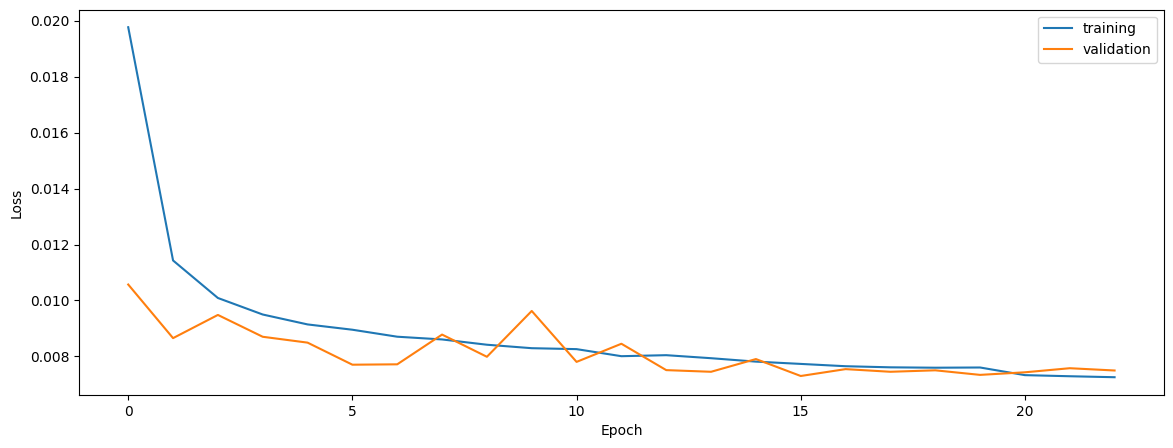

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8467624418210004
0.8335663501955297
0.8348174288077291


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getPearson(train2[1],train_pred2))
print(getPearson(val2[1],val_pred2))
print(getPearson(test2[1],test_pred2))

native
0.75997403918386
0.7401088315693057
0.748210840540974


In [9]:
print('normalized')
print(getPearson(train2[1][train2[2]],train_pred2[train2[2]]))
print(getPearson(val2[1][val2[2]],val_pred2[val2[2]]))
print(getPearson(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.7651188532029561
0.7422930294731251
0.7588903952817557


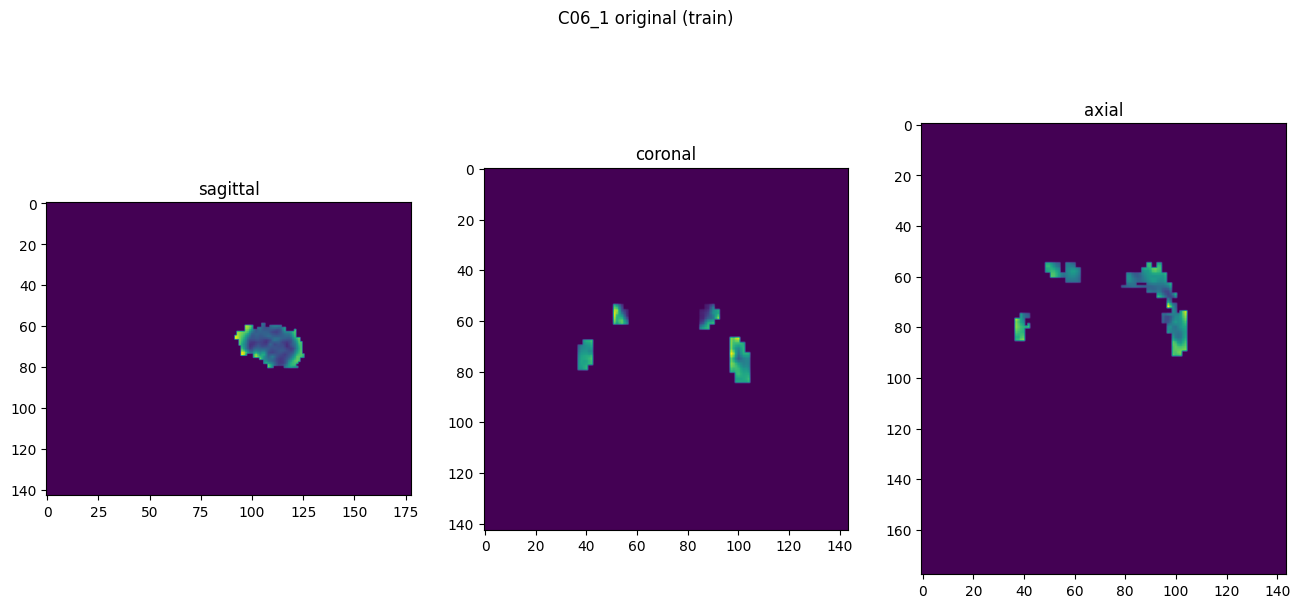

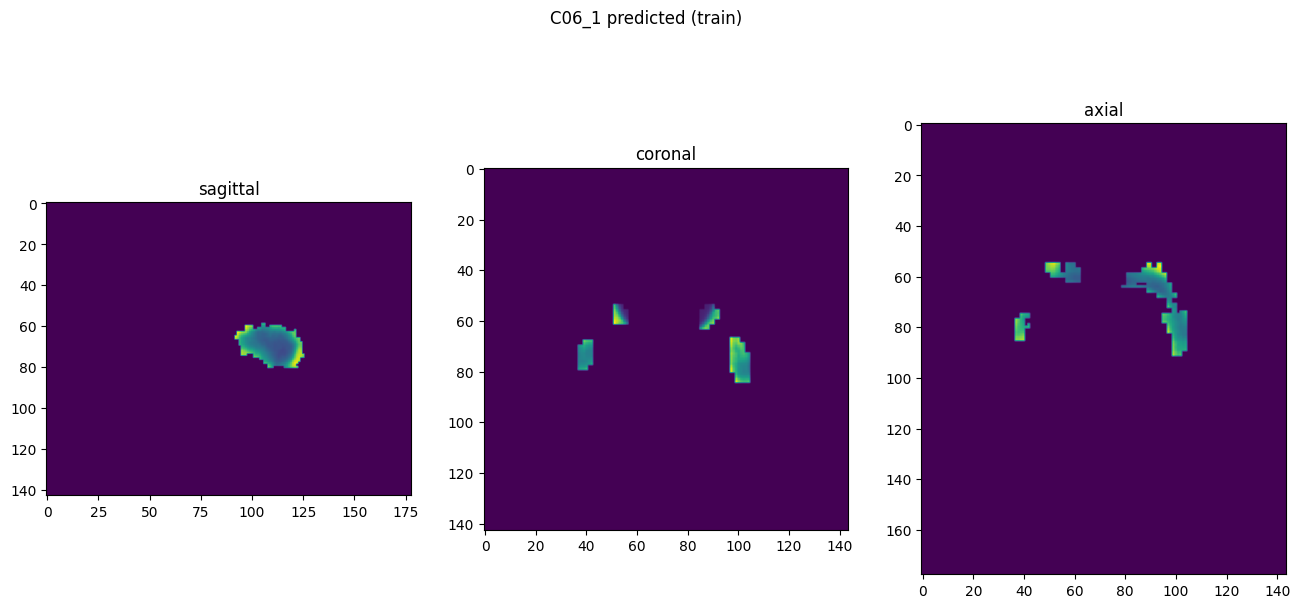

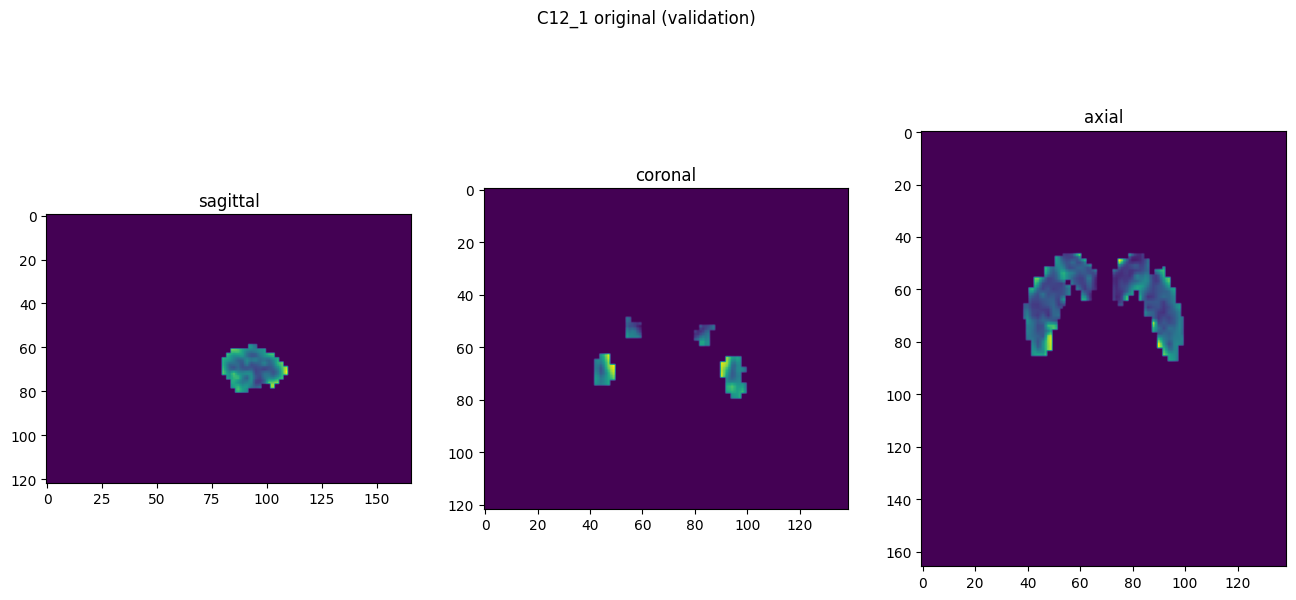

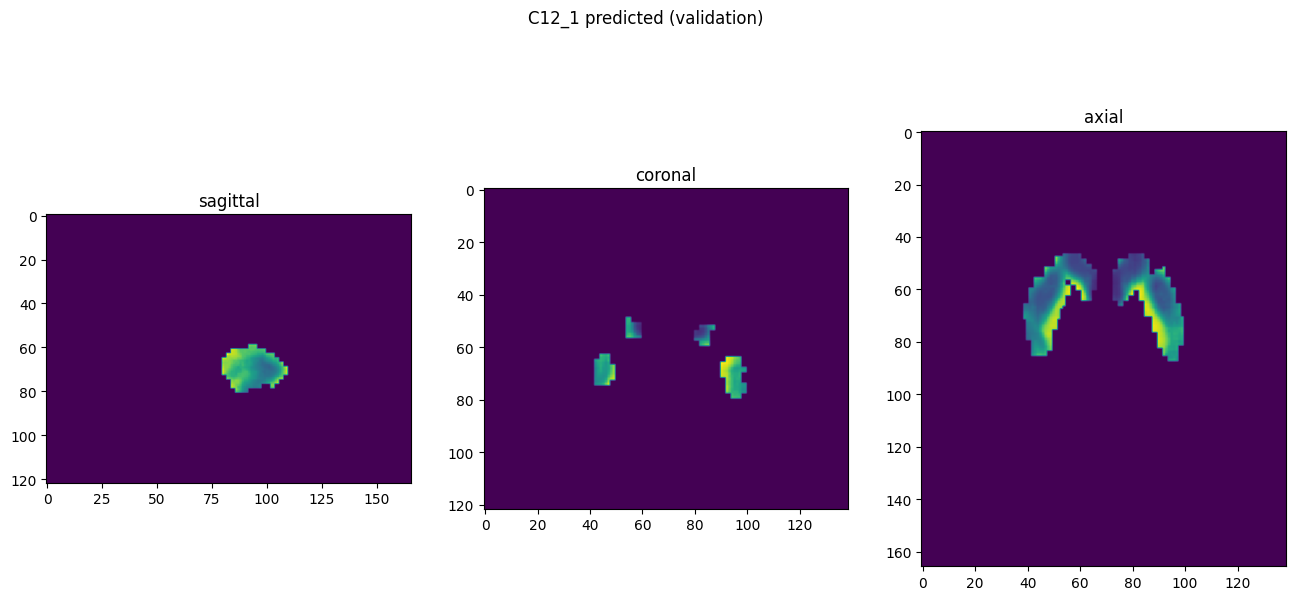

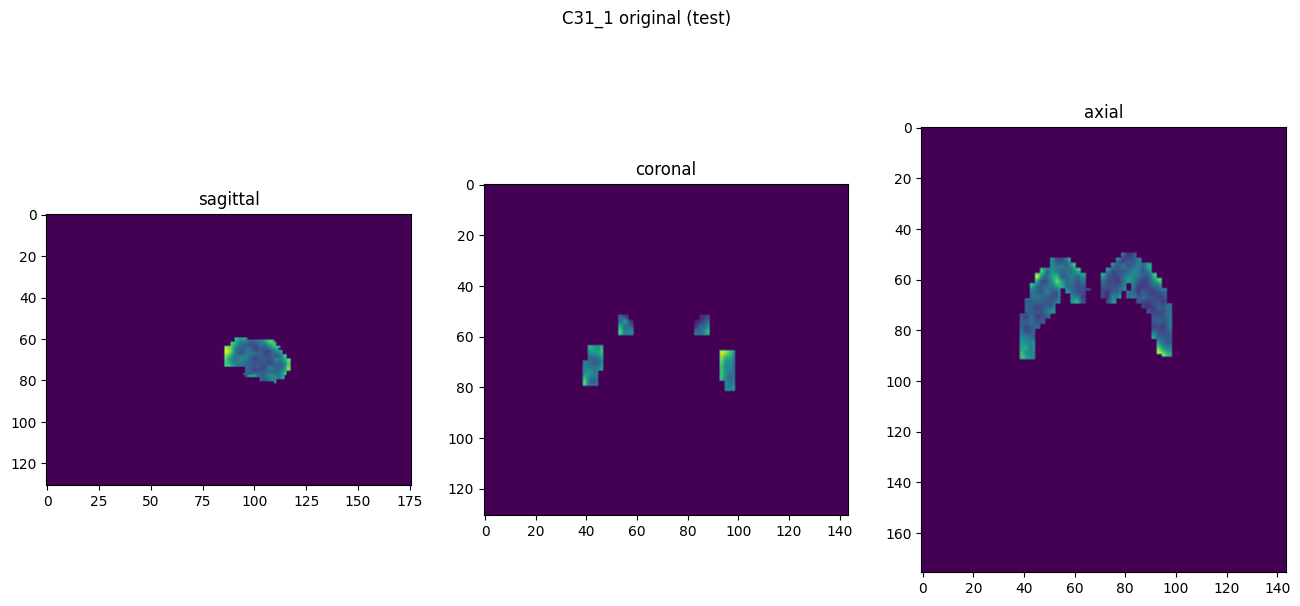

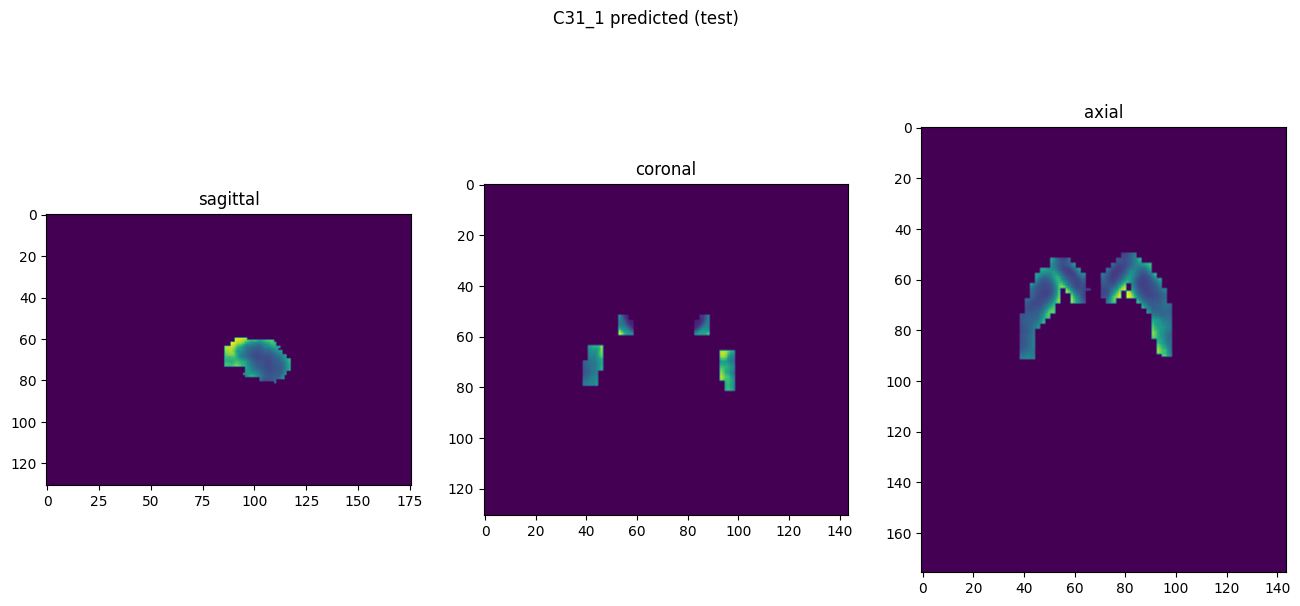

In [10]:
showResults(model, gen, threshold=None, background=False)